In [2]:
# !pip3 install pandas numpy opencv-python matplotlib scipy requests openpyxl cv2

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, savgol_filter
from scipy.fft import fft, fftfreq, ifft
from scipy.signal import find_peaks, argrelmin, argrelmax

In [4]:
# Load the video
video_path = '100_waheeda_1.mp4'
cap = cv2.VideoCapture(video_path)

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Determine block size for 10x10 grid
block_width = width // 10
block_height = height // 10

# Initialize a list to hold the average red values for each block
avg_red_values = np.zeros((10, 10, frame_count), dtype=float)

current_frame = 0

while cap.isOpened() and current_frame < frame_count:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert frame to RGB (if not already in RGB format)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Process each block
    for i in range(10):
        for j in range(10):
            # Define the current block
            block = frame_rgb[i*block_height:(i+1)*block_height, j*block_width:(j+1)*block_width]
            
            # Calculate the average red value for the block
            avg_red = np.mean(block[:, :, 0])  # 0 index for the red channel
            avg_red_values[i, j, current_frame] = avg_red
            
    current_frame += 1

# Close video file
cap.release()

# Selecting frames 51 to 550 due to noise at the start and end of the video
selected_frames = avg_red_values[:, :, 26:276]
selected_frames


array([[[253.60382909, 253.60990548, 253.60908565, ..., 253.63589892,
         253.63392168, 253.64742477],
        [253.35619213, 253.35619213, 253.34153164, ..., 253.61911651,
         253.60966435, 253.68185764],
        [253.48302469, 253.48302469, 253.46412037, ..., 254.08805941,
         254.06621335, 254.13855131],
        ...,
        [253.69376929, 253.69521605, 253.70780285, ..., 253.93475116,
         253.9220679 , 253.97284915],
        [253.43364198, 253.43364198, 253.43364198, ..., 251.09919946,
         251.10908565, 251.36839313],
        [253.12162423, 253.0226659 , 252.83887924, ..., 246.28641011,
         246.28645833, 246.37369792]],

       [[253.59534144, 253.58945795, 253.57826968, ..., 253.73635224,
         253.71966628, 253.7297936 ],
        [253.48490548, 253.48490548, 253.47299383, ..., 254.13083526,
         254.11115934, 254.14737654],
        [254.17824074, 254.1804591 , 254.13425926, ..., 253.82262731,
         253.82204861, 253.82122878],
        ...,


In [5]:
frame_count

300

In [6]:
avg_red_values.shape

(10, 10, 300)

In [7]:
selected_frames.shape

(10, 10, 250)

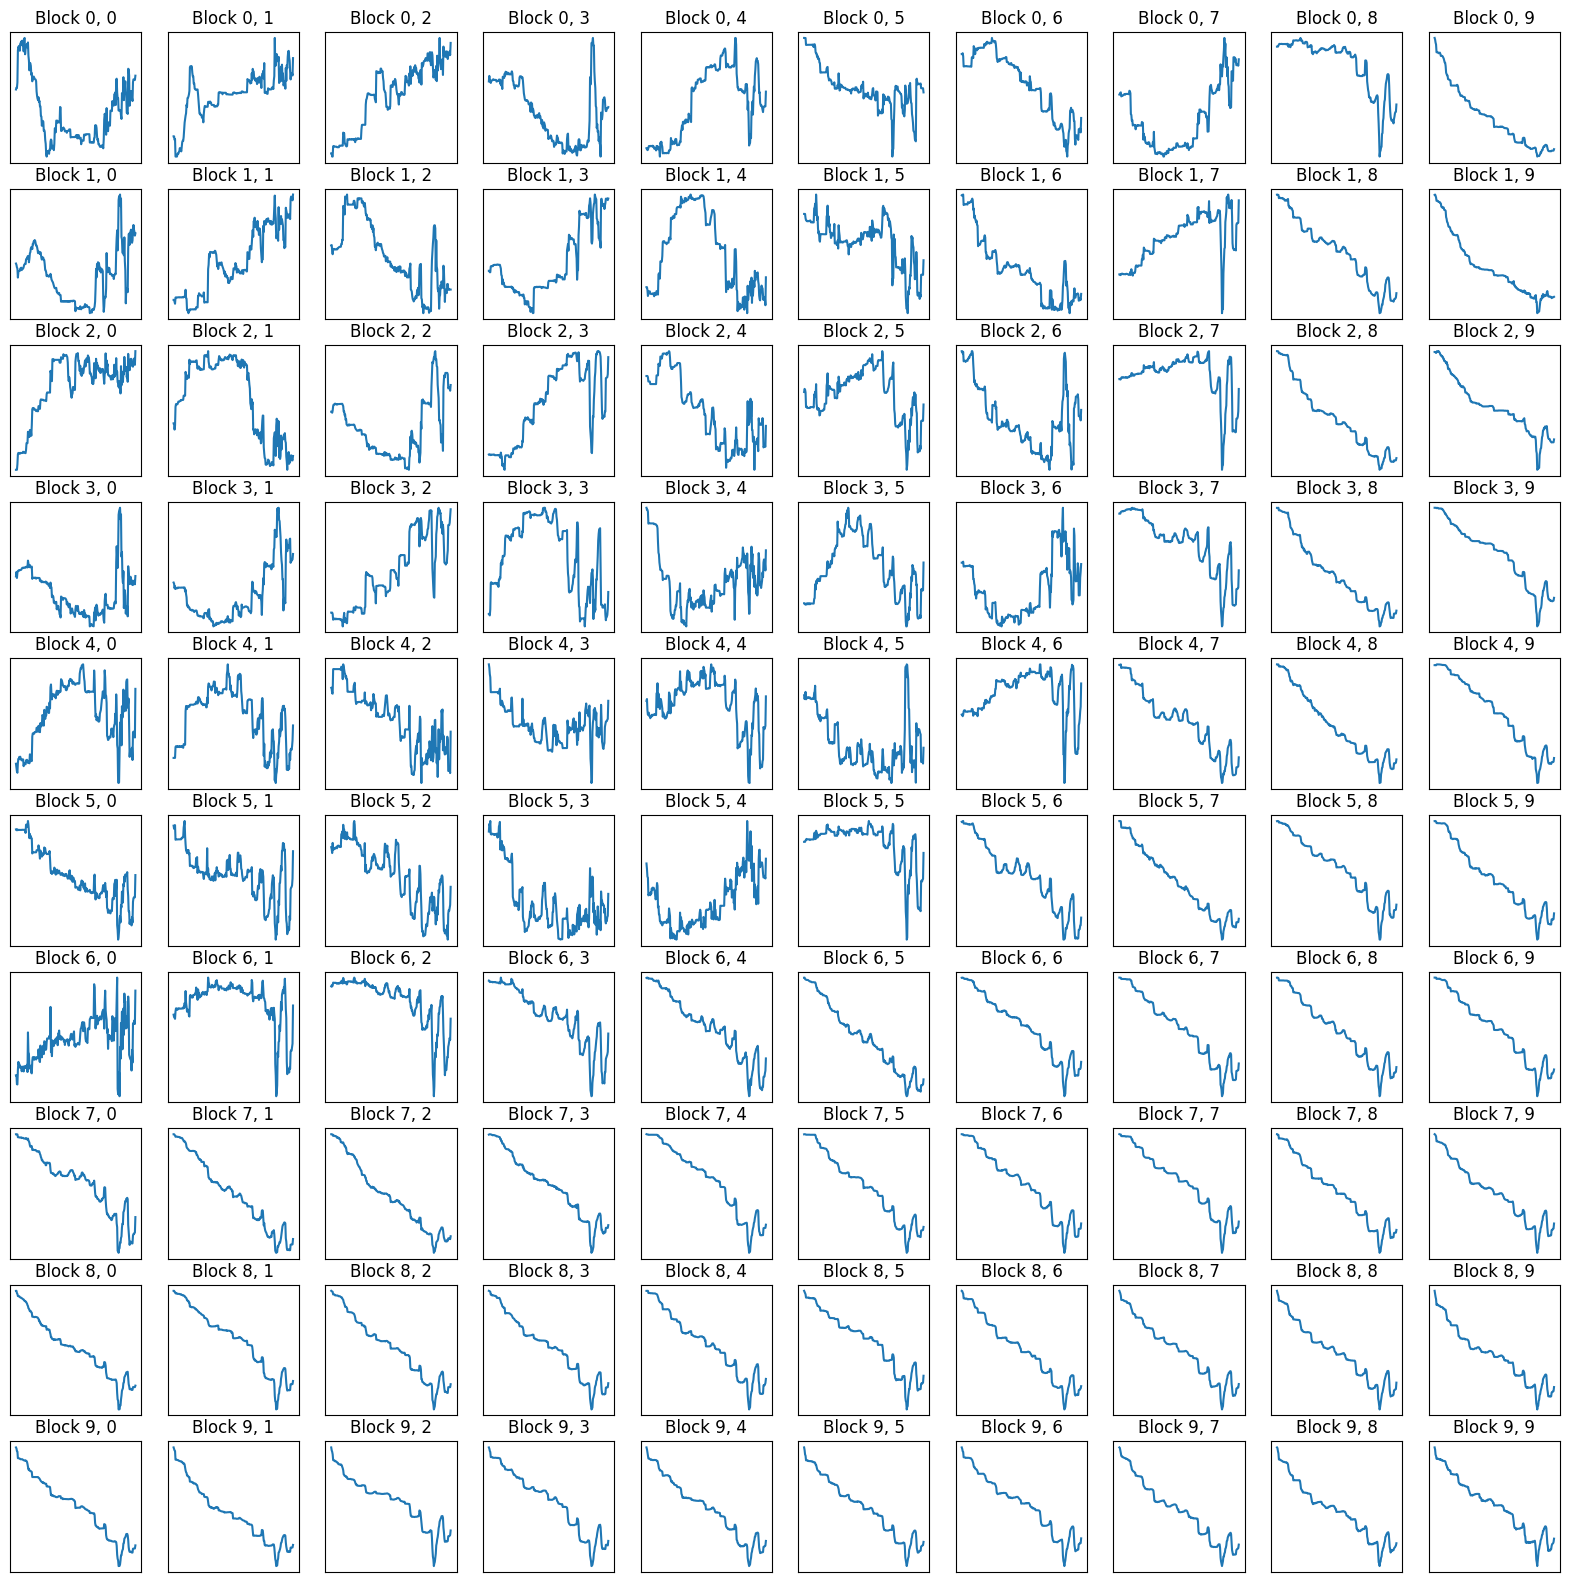

In [8]:
fig, axs = plt.subplots(10, 10, figsize=(20, 20))

for i in range(10):
    for j in range(10):
        axs[i, j].plot(selected_frames[i, j, :])
        axs[i, j].set_title(f'Block {i}, {j}')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
plt.show()



In [9]:
Su = selected_frames

In [10]:
# Define functions for Butterworth filter and FFT
def butterworth_filter(signal, sampling_rate, lowcut, highcut, order=2):
    nyquist_freq = 0.5 * sampling_rate
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = butter(order, [low, high], btype='band', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def apply_fft(signal, sampling_rate, low_freq=0.5, high_freq=5.0):
    n = len(signal)
    freq = fftfreq(n, d=1/sampling_rate)
    fft_signal = fft(signal)

    # Identify indices corresponding to frequencies outside the desired range
    unwanted_indices = (freq < low_freq) | (freq > high_freq)
        
    # Set those frequency components to zero
    fft_signal[unwanted_indices] = 0
        
    # Apply inverse FFT to get the filtered signal
    filtered_signal = ifft(fft_signal)
    return filtered_signal.real


# Parameters for Butterworth filter
lowcut = 0.5  # Hz
highcut = 5.0  # Hz
sampling_rate = fps

# Apply Butterworth filter to each PPG signal
Sc = np.zeros_like(Su)
BF = np.zeros_like(Su)
for i in range(10):
    for j in range(10):
        signal = Su[i, j, :]
        filtered_signal = butterworth_filter(signal, sampling_rate, lowcut, highcut)
        BF[i, j, :] = filtered_signal
        fft_signal = apply_fft(filtered_signal, sampling_rate, lowcut, highcut)
        Sc[i, j, :] = fft_signal

#multiplying Sc with -1 to get SPPG
SPPG = -1 * Sc


In [11]:
SPPG.shape

(10, 10, 250)

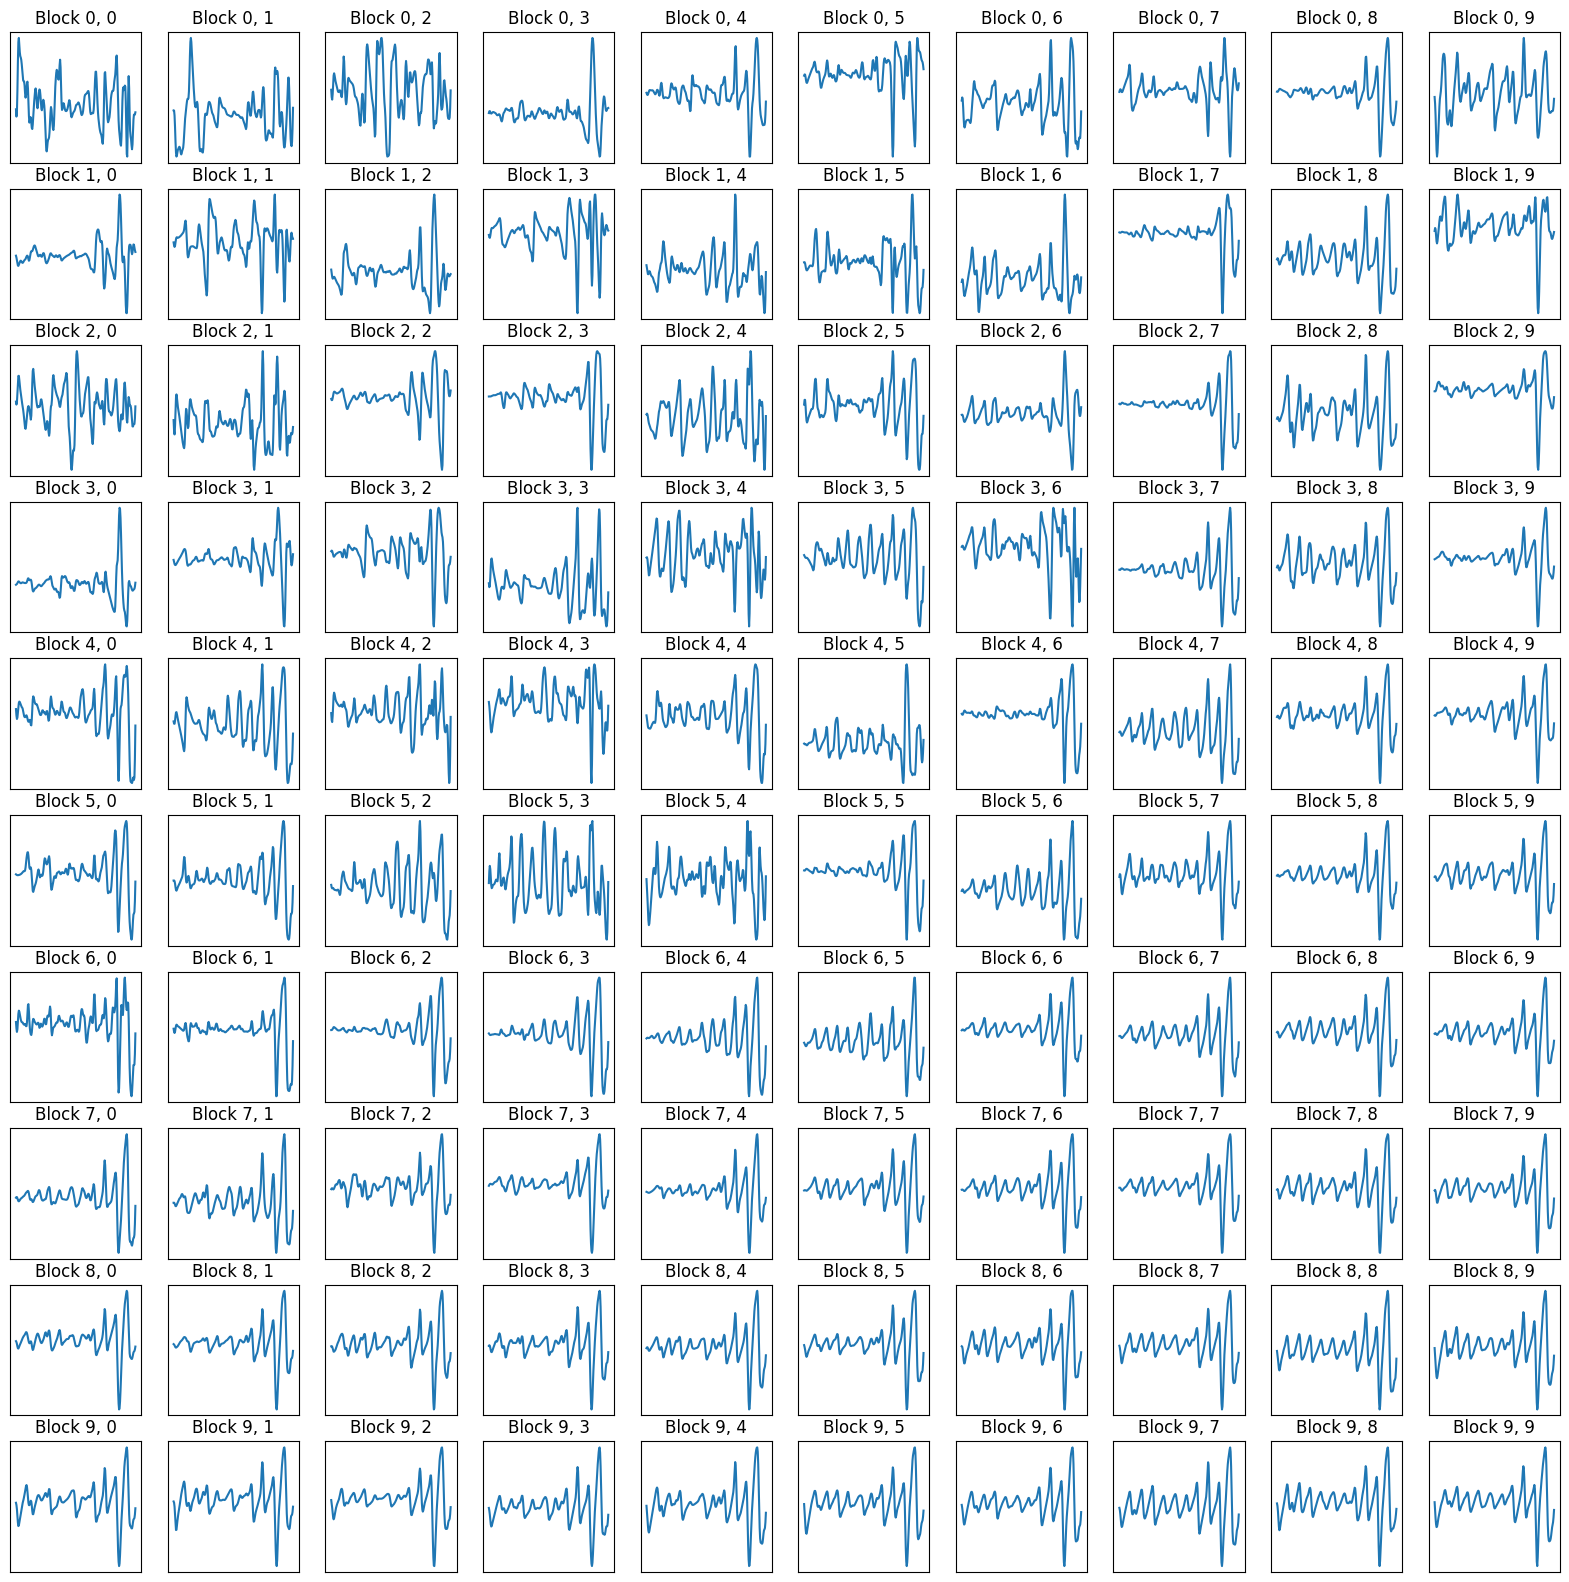

In [12]:
fig, axs = plt.subplots(10, 10, figsize=(20, 20))

for i in range(10):
    for j in range(10):
        axs[i, j].plot(BF[i, j, :])
        axs[i, j].set_title(f'Block {i}, {j}')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
plt.show()



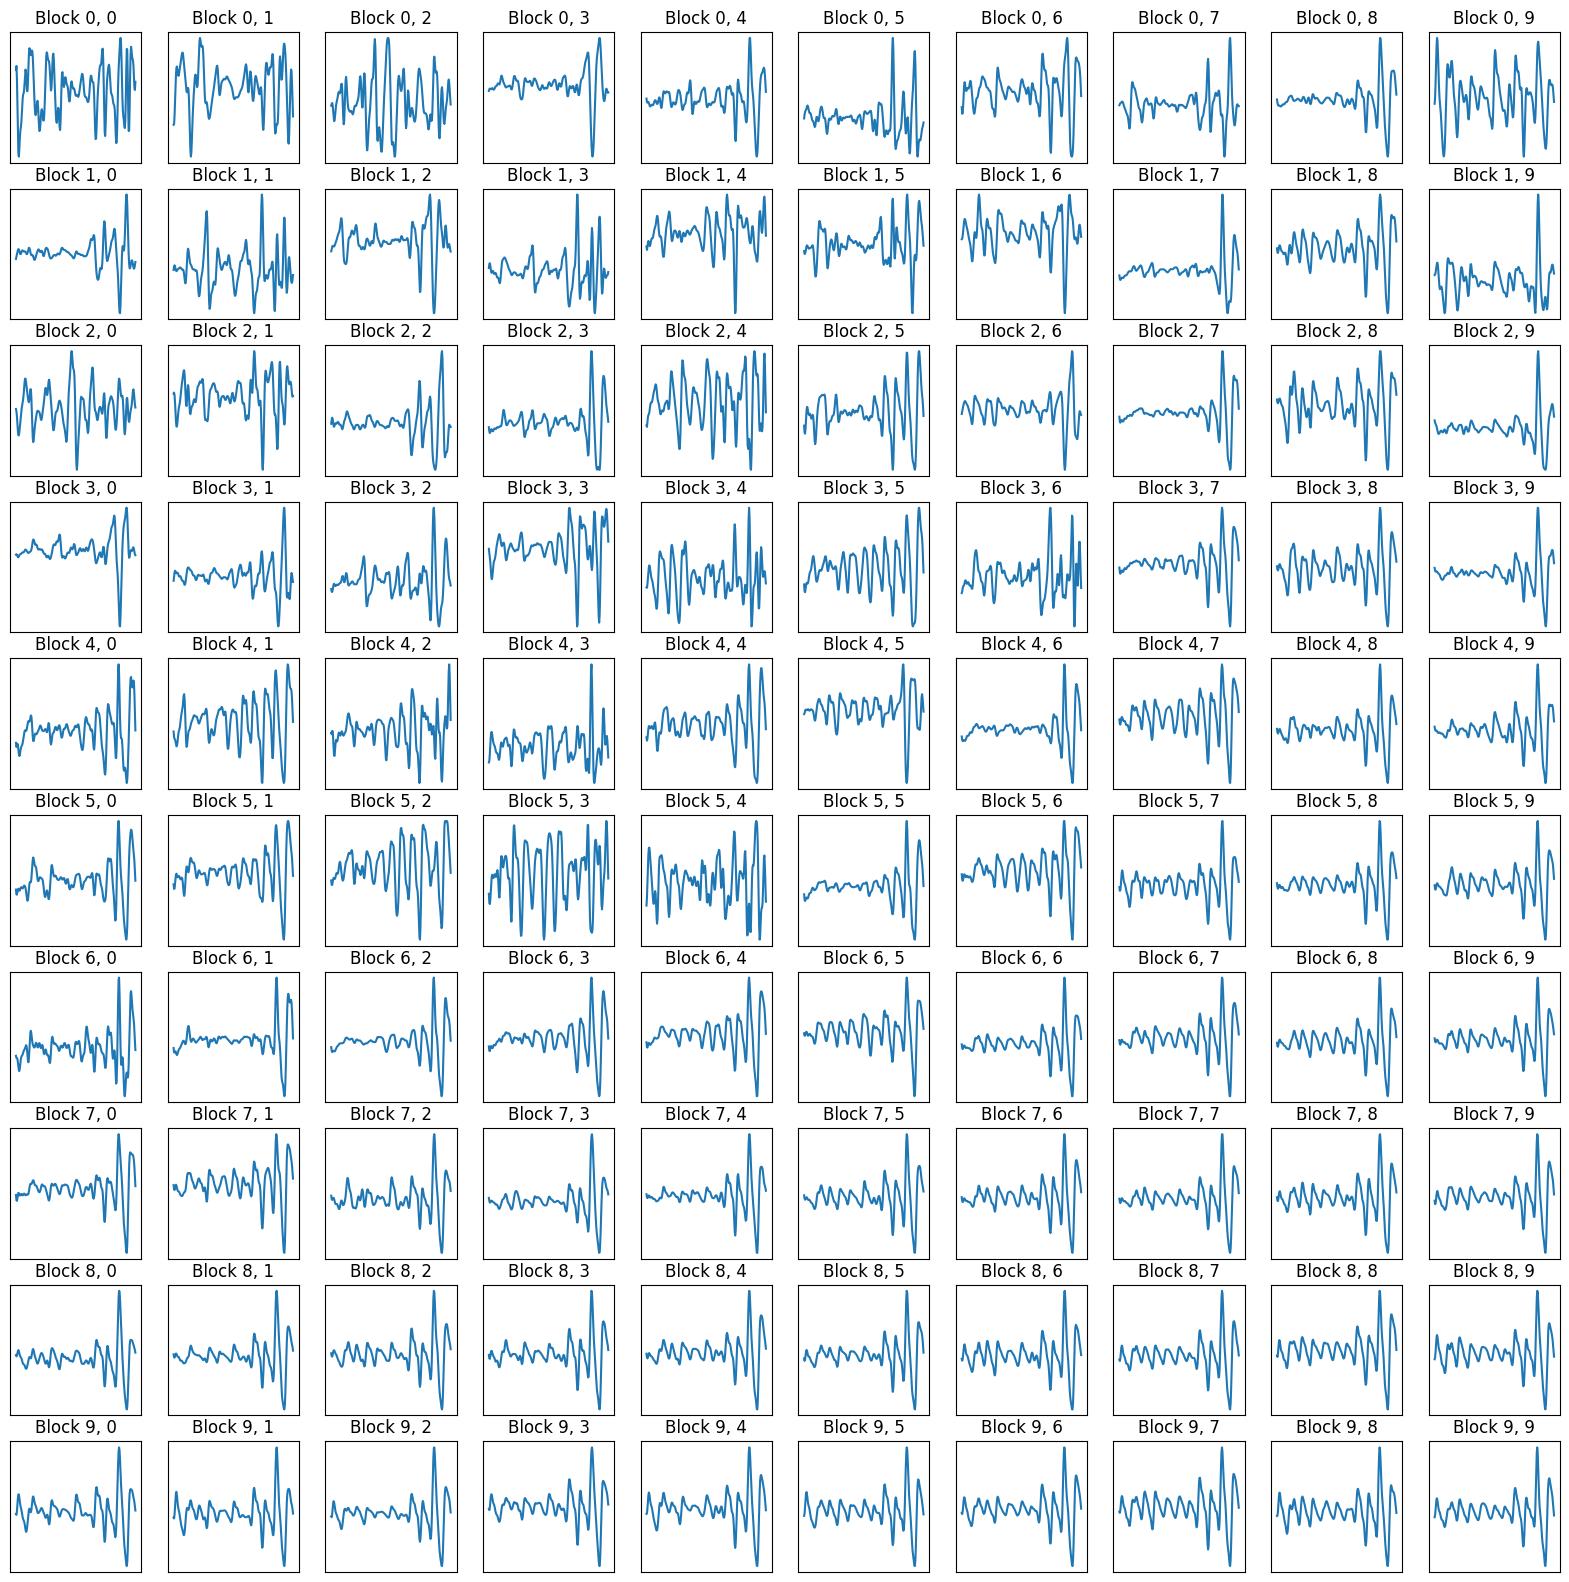

In [13]:
fig, axs = plt.subplots(10, 10, figsize=(20, 20))

for i in range(10):
    for j in range(10):
        axs[i, j].plot(SPPG[i, j, :])
        axs[i, j].set_title(f'Block {i}, {j}')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
plt.show()

In [14]:
# Create a list to hold the average red values for the first block of each frame
first_block_avg_red = []
# Iterate through each frame
for i in range(Su.shape[2]):
    # Extract the average red value for the first block of the current frame
    avg_red = Su[0, 0, i]
    # Append the average red value to the list
    first_block_avg_red.append(avg_red)


# Create a list to hold the average red values for the first block of each frame
first_block_denoised = []
# Iterate through each frame
for i in range(SPPG.shape[2]):
    # Extract the average red value for the first block of the current frame
    avg_red_d = SPPG[0, 0, i]
    # Append the average red value to the list
    first_block_denoised.append(avg_red_d)



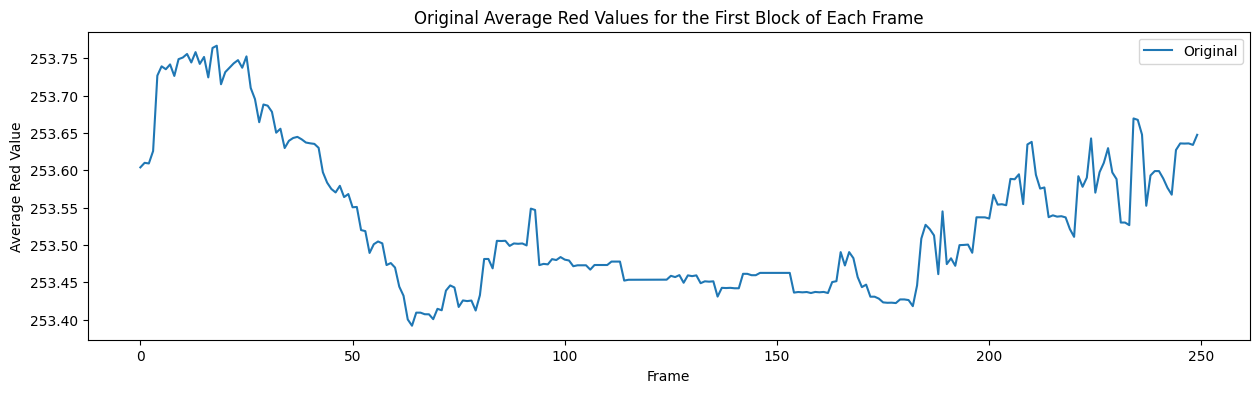

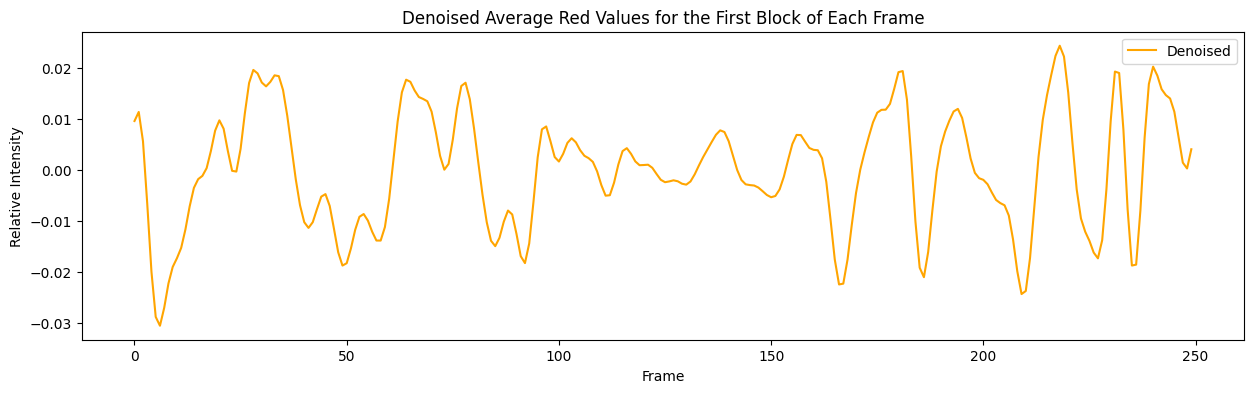

In [15]:
# Plot first_block_avg_red
plt.figure(figsize=(15, 4))
plt.plot(first_block_avg_red, label='Original')
plt.xlabel('Frame')
plt.ylabel('Average Red Value')
plt.title('Original Average Red Values for the First Block of Each Frame')
plt.legend()
plt.show()

# Plot first_block_denoised
plt.figure(figsize=(15, 4))
plt.plot(first_block_denoised, color='orange', label='Denoised')
plt.xlabel('Frame')
plt.ylabel('Relative Intensity')
plt.title('Denoised Average Red Values for the First Block of Each Frame')
plt.legend()
plt.show()


In [16]:
def get_expected_cycle_time(ppg_signal, sampling_rate):
    # Compute the FFT of the PPG signal
    fft_signal = fft(ppg_signal)
    
    # Compute the frequency spectrum and corresponding frequencies
    n = len(ppg_signal)
    freq = fftfreq(n, d=1/sampling_rate)
    
    # Find the index of the dominant frequency component
    dominant_freq_idx = np.argmax(np.abs(fft_signal))
    
    # Calculate the period of the dominant frequency component
    dominant_freq = freq[dominant_freq_idx]
    if dominant_freq == 0:
        # Avoid division by zero when the dominant frequency is 0 Hz
        return np.inf
    expected_period = 1 / dominant_freq
    
    # Convert period to cycle time (in seconds)
    expected_cycle_time = expected_period
    
    return expected_cycle_time


def detect_ppg_cycles_for_one_signal(sppg_signal, sampling_rate):
    ppg_cycles = []

    peaks, _ = find_peaks(sppg_signal)
    valleys, _ = find_peaks(-sppg_signal)

    # Ensure peaks and valleys are not empty
    if len(peaks) == 0 or len(valleys) == 0:
        return ppg_cycles

    # # Plot the PPG signal
    # plt.figure(figsize=(15,4))
    # plt.plot(sppg_signal, label='PPG Signal')

    # # Mark peaks and valleys differently
    # plt.scatter(peaks, sppg_signal[peaks], color='red', marker='o', label='Peaks')
    # plt.scatter(valleys, sppg_signal[valleys], color='blue', marker='x', label='Valleys')

    # Mark start_point, systolic_peak, dicrotic_notch, diastolic_peak, and end_point
    for peak_idx in range(len(peaks) - 1):
        for valley_idx in range(len(valleys) - 1):
            start_idx = valleys[valley_idx]
            end_idx = valleys[valley_idx + 1]

            # Check if the current peak is within the current valley
            if start_idx < peaks[peak_idx] < end_idx:
                try:
                    systolic_peak = peaks[peak_idx]
                    diastolic_peak = peaks[peak_idx + 1]
                    start_point = start_idx
                    end_point = valleys[valley_idx + 2]
                    dicrotic_notch = valleys[valley_idx+1]

                    # Check conditions for valid PPG cycle
                    if (sppg_signal[systolic_peak] > sppg_signal[diastolic_peak]):
                        if (sppg_signal[dicrotic_notch] > sppg_signal[start_point] and sppg_signal[dicrotic_notch] > sppg_signal[end_point]):

                            # Calculate time elapsed for PPG cycle
                            cycle_time = (end_point - start_point) / sampling_rate
                            expected_cycle_time = get_expected_cycle_time(sppg_signal, sampling_rate)
                            error_margin = 0.2 * expected_cycle_time
                            # Check if time elapsed is within threshold
                            if abs(cycle_time - expected_cycle_time) <= error_margin:
                                
                                # # Mark each systolic peak and diastolic peak with a different marker
                                # plt.scatter(systolic_peak, sppg_signal[systolic_peak], color='green', marker='^')
                                # plt.scatter(diastolic_peak, sppg_signal[diastolic_peak], color='pink', marker='d')
                                # # Mark each dicrotic notch with a different marker
                                # plt.scatter(dicrotic_notch, sppg_signal[dicrotic_notch], color='purple', marker='*')
                                ppg_cycles.append((start_point, systolic_peak, dicrotic_notch, diastolic_peak, end_point))
                                # # Mark starting and ending point with a different marker
                                # plt.scatter(start_point, sppg_signal[start_point], color='black', marker='P')
                                # plt.scatter(end_point, sppg_signal[end_point], color='orange', marker='s')
                except IndexError:
                    pass
    # # Plot the legend
    # plt.legend()
    # plt.legend(['PPG Signal', 'Systolic Peak', 'Diastolic Peak', 'Dicrotic Notch', 'Start Point', 'End Point'])
    # plt.xlabel('Frame')
    # plt.ylabel('PPG Signal Value')
    # plt.title('Detected Cycles')
    # plt.show()

    return ppg_cycles

# # Example usage
# sampling_rate = fps 
# sppg_signal = SPPG[0, 0, :]  # Assuming we are processing the first PPG signal
# ppg_cycles = detect_ppg_cycles_for_one_signal(sppg_signal, sampling_rate)
# print("Detected PPG cycles:", ppg_cycles)


In [17]:
def select_three_ppg_cycles(ppg_cycles):
    # Sort the detected PPG cycles based on descending systolic heights
    sorted_cycles = sorted(ppg_cycles, key=lambda cycle: cycle[1], reverse=True)
    print("Sorted PPG cycles:", sorted_cycles)

    # If at least three PPG cycles are detected, select the top three based on systolic heights
    if len(sorted_cycles) >= 3:
        selected_cycles = sorted_cycles[:3]
    elif len(sorted_cycles) > 0:
        # If less than three PPG cycles are detected, replicate the PPG cycle with maximum systolic height to get three cycles
        selected_cycles = sorted_cycles
        while len(selected_cycles) < 3:
            selected_cycles.append(sorted_cycles[0])
    else:
        # If no PPG cycles are detected, return an empty list
        selected_cycles = []    
    
    return selected_cycles


In [18]:
def merge_ppg_cycles(sppg_signal, selected_cycles):
    if len(selected_cycles) == 0:
        return None
    
    max_length = max(end_idx - start_idx + 1 for start_idx, _, _, _, end_idx in selected_cycles)
    merged_signal = np.zeros(max_length)
    num_cycles = len(selected_cycles)
    
    for cycle in selected_cycles:
        start_idx, systolic_peak_idx, dicrotic_notch_idx, diastolic_peak_idx, end_idx = cycle
        cycle_signal = sppg_signal[start_idx:end_idx+1]
        
        # Pad cycle signal if necessary
        if len(cycle_signal) < max_length:
            pad_length = max_length - len(cycle_signal)
            cycle_signal = np.pad(cycle_signal, (0, pad_length), mode='constant')
        
        merged_signal += cycle_signal
    
    # Take the average of the summed signals
    merged_signal /= num_cycles
    
    return merged_signal

In [19]:
def visualize_merged_signal(merged_signal, sampling_rate):
    if merged_signal is None:
        print("No merged signal to visualize.")
        return
    
    # Calculate time axis based on sampling rate
    time_axis = np.arange(len(merged_signal)) / sampling_rate
    
    # Plot the merged signal
    plt.figure()
    plt.plot(time_axis, merged_signal, color='blue')
    plt.xlabel('Time (seconds)')
    plt.ylabel('PPG Signal Value')
    plt.title('Merged PPG Signal')
    plt.grid(True)
    plt.show()

Detected PPG cycles for block 0, 0: []
Sorted PPG cycles: []
Selected PPG cycles 0, 0: []
Merged PPG signal: None
No merged signal to visualize.
Detected PPG cycles for block 0, 1: [(133, 151, 156, 160, 166)]
Sorted PPG cycles: [(133, 151, 156, 160, 166)]
Selected PPG cycles 0, 1: [(133, 151, 156, 160, 166), (133, 151, 156, 160, 166), (133, 151, 156, 160, 166)]
Merged PPG signal: [-0.00802637 -0.00782768 -0.00741058 -0.00679002 -0.00594928 -0.00492676
 -0.00388719 -0.00303363 -0.0024054  -0.00177464 -0.00079126  0.00073025
  0.0026682   0.00476189  0.00692266  0.00931351  0.01200762  0.01449135
  0.01556427  0.01395906  0.00937407  0.0031215  -0.00226395 -0.00436811
 -0.00233925  0.00256414  0.00768995  0.01045505  0.00958751  0.00547788
 -0.00032121 -0.00590584 -0.00964708 -0.01052897]


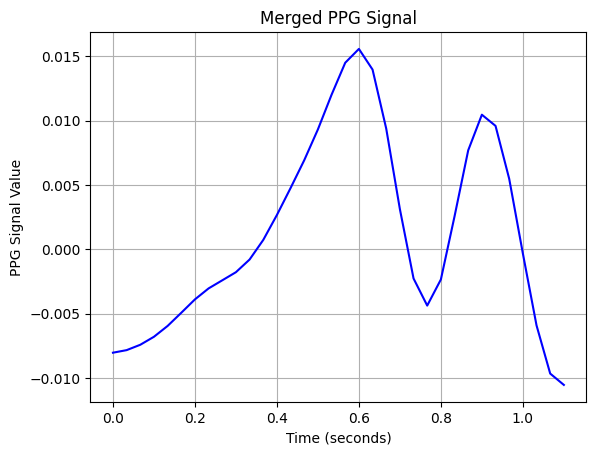

Detected PPG cycles for block 0, 2: [(75, 91, 97, 100, 105), (105, 119, 127, 129, 133)]
Sorted PPG cycles: [(105, 119, 127, 129, 133), (75, 91, 97, 100, 105)]
Selected PPG cycles 0, 2: [(105, 119, 127, 129, 133), (75, 91, 97, 100, 105), (105, 119, 127, 129, 133)]
Merged PPG signal: [-0.0391804  -0.03593546 -0.02844471 -0.01904697 -0.01011712 -0.0027854
  0.00350396  0.0101545   0.01791106  0.02597969  0.03262542  0.03677753
  0.03913242  0.04153721  0.04495787  0.04778282  0.04620813  0.03682047
  0.01954709 -0.00141868 -0.01968495 -0.03038098 -0.03288177 -0.030657
 -0.02854999 -0.02960727 -0.0336339  -0.03808607 -0.04015581 -0.01277925
 -0.01318785]


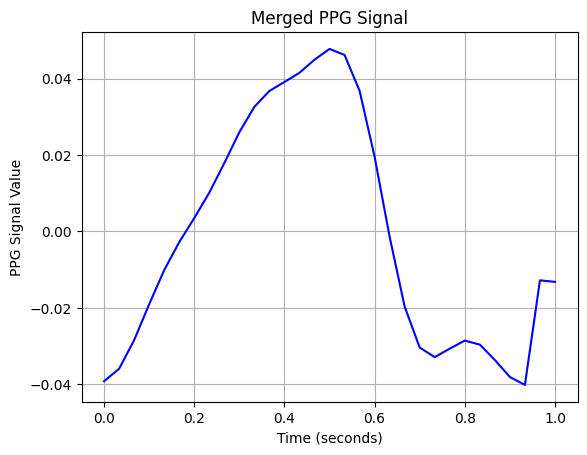

Detected PPG cycles for block 0, 3: [(47, 53, 58, 60, 68), (68, 76, 82, 86, 90)]
Sorted PPG cycles: [(68, 76, 82, 86, 90), (47, 53, 58, 60, 68)]
Selected PPG cycles 0, 3: [(68, 76, 82, 86, 90), (47, 53, 58, 60, 68), (68, 76, 82, 86, 90)]
Merged PPG signal: [-0.03887659 -0.03831515 -0.03345878 -0.02335251 -0.00895348  0.00650649
  0.01877845  0.02480832  0.02439434  0.02008635  0.01539582  0.01262748
  0.01185424  0.0115829   0.01032658  0.00771134  0.00433581  0.00078893
 -0.00305657 -0.00772005 -0.01306524 -0.01760187 -0.00234734]


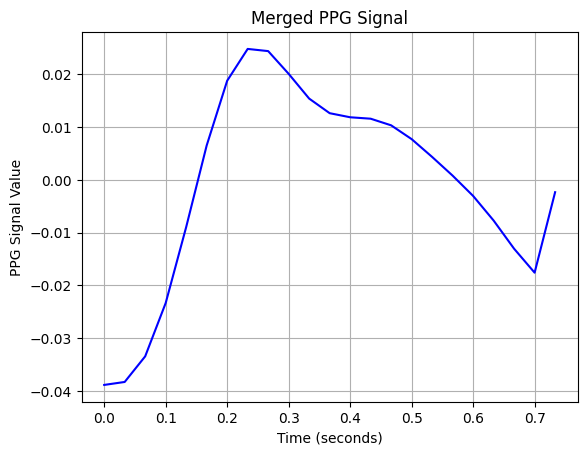

Detected PPG cycles for block 0, 4: [(186, 191, 200, 202, 208)]
Sorted PPG cycles: [(186, 191, 200, 202, 208)]
Selected PPG cycles 0, 4: [(186, 191, 200, 202, 208), (186, 191, 200, 202, 208), (186, 191, 200, 202, 208)]
Merged PPG signal: [-0.13416195 -0.10498712 -0.05017106  0.00808016  0.04829803  0.0610773
  0.05206208  0.03540942  0.02322394  0.01870933  0.01714853  0.01248752
  0.0033806  -0.006097   -0.01084901 -0.00981846 -0.00721597 -0.00917229
 -0.01903161 -0.03524042 -0.05299805 -0.06738256 -0.07479466]


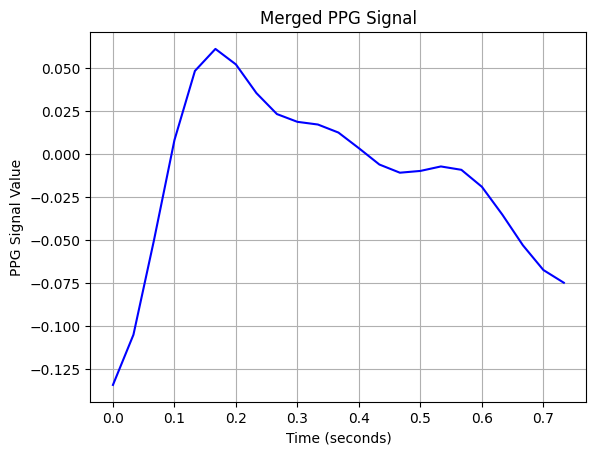

Detected PPG cycles for block 0, 5: [(191, 207, 212, 216, 220)]
Sorted PPG cycles: [(191, 207, 212, 216, 220)]
Selected PPG cycles 0, 5: [(191, 207, 212, 216, 220), (191, 207, 212, 216, 220), (191, 207, 212, 216, 220)]
Merged PPG signal: [-0.10691657 -0.09908324 -0.08643038 -0.0785771  -0.07528276 -0.07158873
 -0.06431869 -0.05483125 -0.04695281 -0.04281208 -0.04023716 -0.03356915
 -0.01717083  0.0105968   0.04512805  0.07629628  0.09216464  0.0844448
  0.05335038  0.00910233 -0.03158273 -0.05314285 -0.04931757 -0.02710087
 -0.00363148  0.00289087 -0.01655263 -0.05626234 -0.09837308 -0.1222576 ]


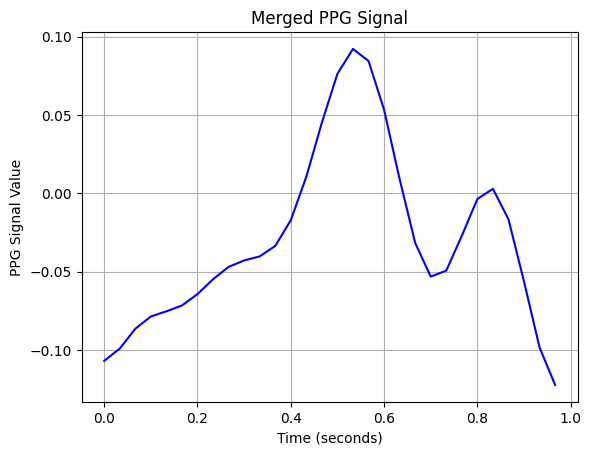

Detected PPG cycles for block 0, 6: [(91, 98, 106, 109, 117), (117, 126, 135, 139, 143), (162, 169, 173, 174, 186), (186, 191, 194, 198, 208)]
Sorted PPG cycles: [(186, 191, 194, 198, 208), (162, 169, 173, 174, 186), (117, 126, 135, 139, 143), (91, 98, 106, 109, 117)]
Selected PPG cycles 0, 6: [(186, 191, 194, 198, 208), (162, 169, 173, 174, 186), (117, 126, 135, 139, 143)]
Merged PPG signal: [-0.0487715  -0.04234822 -0.02724743 -0.0078127   0.01039383  0.02311564
  0.02893289  0.02918097  0.02663056  0.02385946  0.02215982  0.02134533
  0.02033067  0.01806148  0.0142859   0.00974364  0.00562166  0.00255992
 -0.00011896 -0.00426441 -0.01167028 -0.02241708 -0.03395486 -0.03011446
 -0.03412797 -0.00596293 -0.00658486]


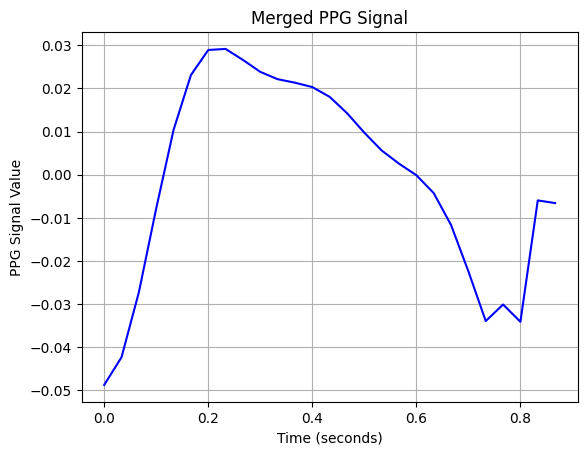

Detected PPG cycles for block 0, 7: [(47, 56, 62, 66, 71)]
Sorted PPG cycles: [(47, 56, 62, 66, 71)]
Selected PPG cycles 0, 7: [(47, 56, 62, 66, 71), (47, 56, 62, 66, 71), (47, 56, 62, 66, 71)]
Merged PPG signal: [-3.83950051e-02 -3.59889665e-02 -2.62482575e-02 -1.33459910e-02
 -2.24181958e-03  4.51020564e-03  7.69414101e-03  9.69802602e-03
  1.19470939e-02  1.37967461e-02  1.36046290e-02  1.06755270e-02
  6.15303106e-03  2.13939122e-03  5.85140264e-05 -1.46502178e-04
  5.87414305e-04  1.54207423e-03  2.51269002e-03  3.04531500e-03
  1.71509167e-03 -3.28942440e-03 -1.23271638e-02 -2.28082720e-02
 -2.97925686e-02]


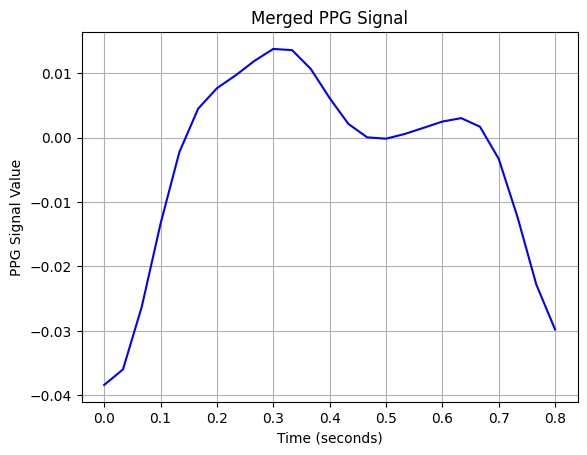

Detected PPG cycles for block 0, 8: [(70, 75, 80, 83, 93), (118, 125, 130, 131, 141)]
Sorted PPG cycles: [(118, 125, 130, 131, 141), (70, 75, 80, 83, 93)]
Selected PPG cycles 0, 8: [(118, 125, 130, 131, 141), (70, 75, 80, 83, 93), (118, 125, 130, 131, 141)]
Merged PPG signal: [-0.05163635 -0.04623943 -0.02400748  0.00862059  0.04041891  0.06143472
  0.06781244  0.06254532  0.05235376  0.04336629  0.03846303  0.03729548
  0.03791016  0.03821886  0.03645466  0.03105333  0.02083161  0.00568127
 -0.01286756 -0.03196178 -0.04859511 -0.06076955 -0.06775579 -0.06940845]


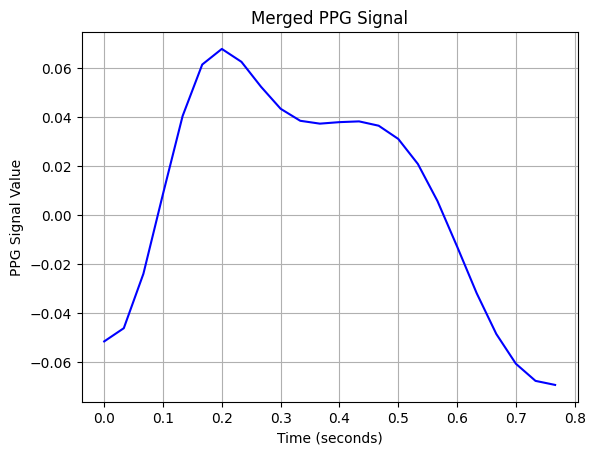

Detected PPG cycles for block 0, 9: [(47, 54, 61, 66, 71), (186, 192, 196, 199, 209)]
Sorted PPG cycles: [(186, 192, 196, 199, 209), (47, 54, 61, 66, 71)]
Selected PPG cycles 0, 9: [(186, 192, 196, 199, 209), (47, 54, 61, 66, 71), (186, 192, 196, 199, 209)]
Merged PPG signal: [-0.16859853 -0.14842409 -0.10125311 -0.04559515  0.00039237  0.02696612
  0.03472231  0.03084252  0.0233483   0.0171495   0.01337329  0.01097693
  0.00869637  0.00605831  0.0033657   0.00117841 -0.00030364 -0.00180508
 -0.00525486 -0.01330037 -0.02773908 -0.04736139 -0.06661542 -0.07659176
 -0.02385507]


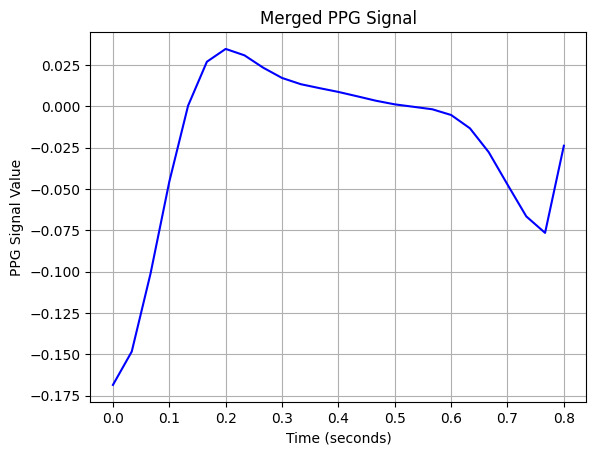

Detected PPG cycles for block 1, 0: [(39, 47, 51, 53, 58)]
Sorted PPG cycles: [(39, 47, 51, 53, 58)]
Selected PPG cycles 1, 0: [(39, 47, 51, 53, 58), (39, 47, 51, 53, 58), (39, 47, 51, 53, 58)]
Merged PPG signal: [-0.01303805 -0.01120445 -0.00789036 -0.00429319 -0.00107256  0.00180252
  0.00449983  0.00671616  0.0076997   0.00694845  0.00491655  0.00295924
  0.00239636  0.00341245  0.0047661   0.00467218  0.00223624 -0.00169345
 -0.00496945 -0.00557671]


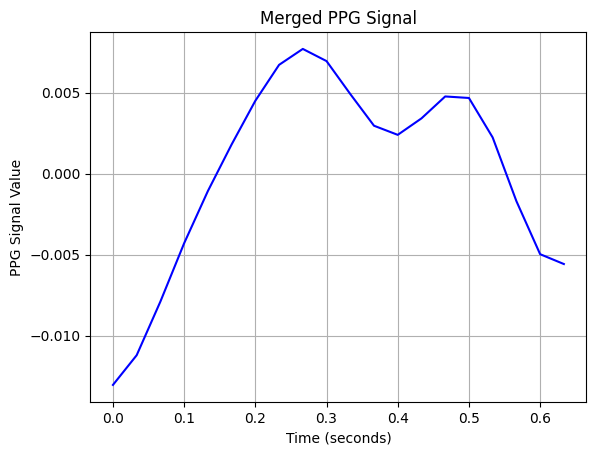

Detected PPG cycles for block 1, 1: [(128, 151, 156, 158, 168)]
Sorted PPG cycles: [(128, 151, 156, 158, 168)]
Selected PPG cycles 1, 1: [(128, 151, 156, 158, 168), (128, 151, 156, 158, 168), (128, 151, 156, 158, 168)]
Merged PPG signal: [-3.55454633e-02 -3.50791756e-02 -3.18984215e-02 -2.67712401e-02
 -2.11616743e-02 -1.65218952e-02 -1.32923101e-02 -1.05564665e-02
 -6.86251263e-03 -1.63065185e-03  4.12277352e-03  8.51783909e-03
  1.04415108e-02  1.05933853e-02  1.09115412e-02  1.28443669e-02
  1.60907804e-02  1.90668117e-02  2.07075381e-02  2.18156164e-02
  2.44448834e-02  2.96517133e-02  3.56865063e-02  3.85957168e-02
  3.51479186e-02  2.57538502e-02  1.47382452e-02  7.42193200e-03
  6.24878251e-03  9.15413548e-03  1.15411953e-02  1.01309609e-02
  5.32539423e-03  7.92881309e-05 -3.54547887e-03 -6.82435045e-03
 -1.33733101e-02 -2.54505137e-02 -4.09171917e-02 -5.38425156e-02
 -5.85885269e-02]


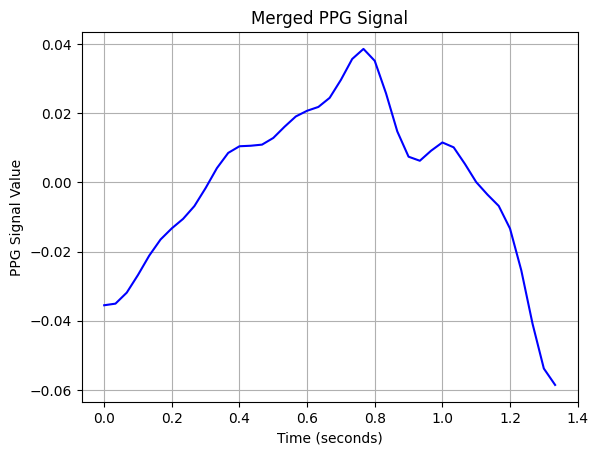

Detected PPG cycles for block 1, 2: [(214, 225, 234, 239, 243)]
Sorted PPG cycles: [(214, 225, 234, 239, 243)]
Selected PPG cycles 1, 2: [(214, 225, 234, 239, 243), (214, 225, 234, 239, 243), (214, 225, 234, 239, 243)]
Merged PPG signal: [-0.19004052 -0.18916304 -0.17244032 -0.14284016 -0.10569038 -0.06648833
 -0.02835409  0.00842108  0.04403326  0.07610608  0.09906703  0.10719267
  0.09914163  0.08000639  0.05863148  0.04192801  0.03072028  0.02065593
  0.00752117 -0.0075653  -0.01774307 -0.0155508   0.00037177  0.02260296
  0.03886031  0.03989238  0.02551662  0.00436347 -0.01231922 -0.01808916]


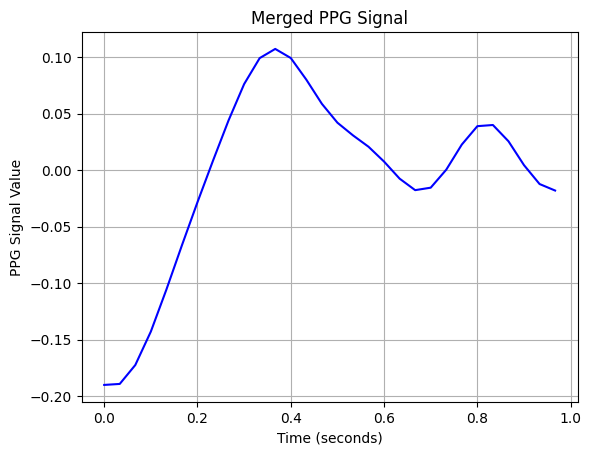

Detected PPG cycles for block 1, 3: []
Sorted PPG cycles: []
Selected PPG cycles 1, 3: []
Merged PPG signal: None
No merged signal to visualize.
Detected PPG cycles for block 1, 4: [(7, 22, 28, 29, 35)]
Sorted PPG cycles: [(7, 22, 28, 29, 35)]
Selected PPG cycles 1, 4: [(7, 22, 28, 29, 35), (7, 22, 28, 29, 35), (7, 22, 28, 29, 35)]
Merged PPG signal: [-0.02734025 -0.02501934 -0.01910829 -0.01360466 -0.01115512 -0.01105404
 -0.01036748 -0.00683662 -0.00083297  0.00527583  0.00956223  0.01241333
  0.01608116  0.02229188  0.03005958  0.03571666  0.0353119   0.02755172
  0.01499823  0.0025967  -0.00538466 -0.00784239 -0.0071646  -0.00742068
 -0.01180047 -0.0209037  -0.0326406  -0.04342074 -0.04974699]


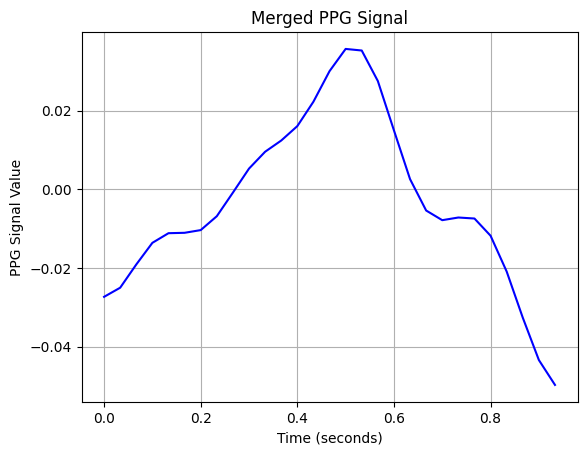

Detected PPG cycles for block 1, 5: [(24, 32, 40, 43, 49)]
Sorted PPG cycles: [(24, 32, 40, 43, 49)]
Selected PPG cycles 1, 5: [(24, 32, 40, 43, 49), (24, 32, 40, 43, 49), (24, 32, 40, 43, 49)]
Merged PPG signal: [-0.05920578 -0.05621799 -0.0465301  -0.03146326 -0.01266962  0.0074771
  0.02561771  0.03817775  0.04307265  0.04109897  0.03566097  0.03070989
  0.02833267  0.02787618  0.02729209  0.02548584  0.02352764  0.02353786
  0.02614892  0.02885615  0.02700052  0.01696665 -0.00076853 -0.02116623
 -0.03724867 -0.04398878]


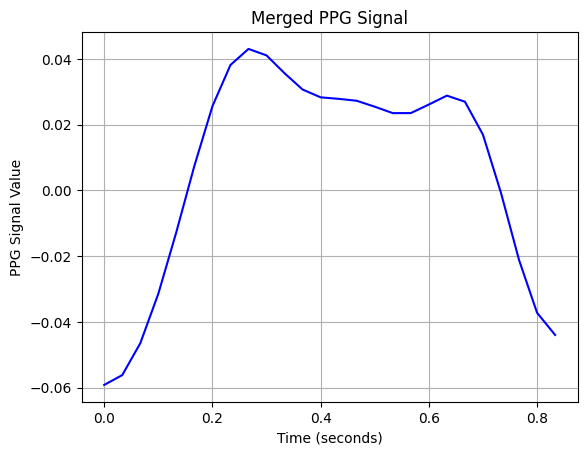

Detected PPG cycles for block 1, 6: [(47, 53, 57, 59, 70), (70, 77, 80, 82, 96), (118, 125, 128, 130, 142), (215, 225, 236, 238, 241)]
Sorted PPG cycles: [(215, 225, 236, 238, 241), (118, 125, 128, 130, 142), (70, 77, 80, 82, 96), (47, 53, 57, 59, 70)]
Selected PPG cycles 1, 6: [(215, 225, 236, 238, 241), (118, 125, 128, 130, 142), (70, 77, 80, 82, 96)]
Merged PPG signal: [-0.08277288 -0.07537588 -0.0576157  -0.03376542 -0.00915684  0.0119495
  0.02756436  0.03775505  0.04352417  0.04579042  0.04513454  0.04215937
  0.03778198  0.03298043  0.02820285  0.02310562  0.01703731  0.00994165
  0.00283921 -0.00268357 -0.00567182 -0.00667333 -0.0074267  -0.00947119
 -0.01275078 -0.01183587 -0.01373639]


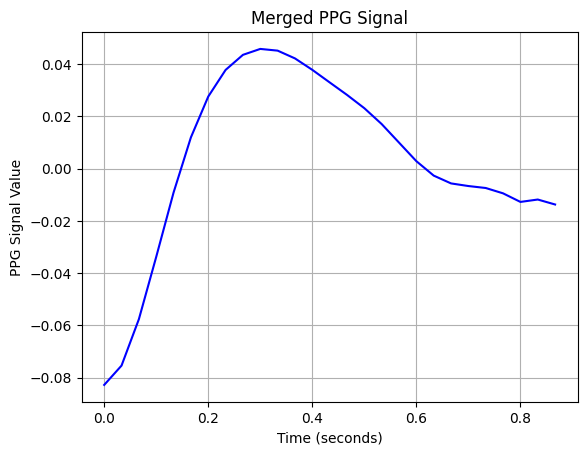

Detected PPG cycles for block 1, 7: []
Sorted PPG cycles: []
Selected PPG cycles 1, 7: []
Merged PPG signal: None
No merged signal to visualize.
Detected PPG cycles for block 1, 8: [(185, 192, 195, 197, 208)]
Sorted PPG cycles: [(185, 192, 195, 197, 208)]
Selected PPG cycles 1, 8: [(185, 192, 195, 197, 208), (185, 192, 195, 197, 208), (185, 192, 195, 197, 208)]
Merged PPG signal: [-0.39725462 -0.38440851 -0.29878021 -0.16963621 -0.04050648  0.05226457
  0.09441846  0.09509081  0.07633226  0.05888635  0.05263538  0.05560971
  0.05975976  0.0583462   0.05013839  0.03858288  0.02751258  0.01689588
  0.00177871 -0.02459407 -0.0651668  -0.11433851 -0.15721659 -0.17392183]


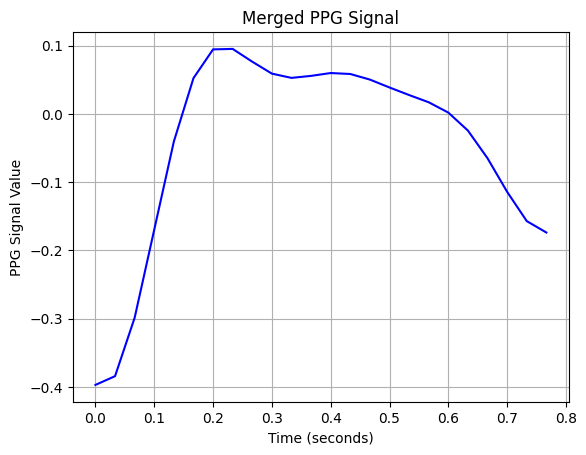

Detected PPG cycles for block 1, 9: [(21, 28, 33, 36, 48)]
Sorted PPG cycles: [(21, 28, 33, 36, 48)]
Selected PPG cycles 1, 9: [(21, 28, 33, 36, 48), (21, 28, 33, 36, 48), (21, 28, 33, 36, 48)]
Merged PPG signal: [-0.08941714 -0.08446737 -0.06476063 -0.0326562   0.00400065  0.03545743
  0.05492317  0.06143553  0.05904932  0.05345017  0.04871356  0.04622325
  0.04564856  0.04634447  0.04778118  0.04905709  0.0485999   0.04480876
  0.03715568  0.0265544   0.01443826  0.00134792 -0.01350589 -0.03104885
 -0.05045497 -0.06834123 -0.08002686 -0.08206358]


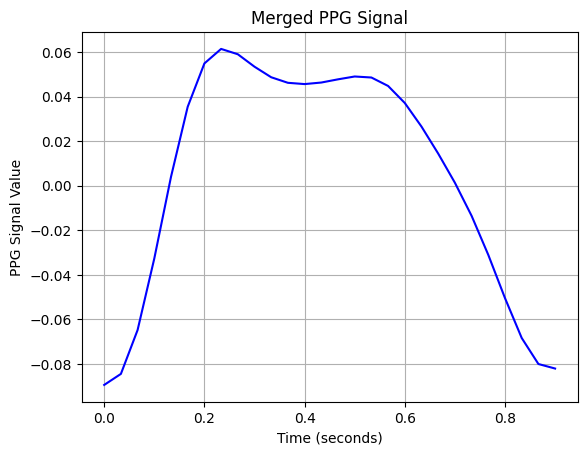

Detected PPG cycles for block 2, 0: [(6, 19, 27, 31, 36), (127, 136, 139, 140, 150)]
Sorted PPG cycles: [(127, 136, 139, 140, 150), (6, 19, 27, 31, 36)]
Selected PPG cycles 2, 0: [(127, 136, 139, 140, 150), (6, 19, 27, 31, 36), (127, 136, 139, 140, 150)]
Merged PPG signal: [-0.04261878 -0.03838834 -0.03078955 -0.02329924 -0.01704603 -0.01123022
 -0.00501119  0.00115717  0.0059195   0.00848889  0.00952685  0.01047265
  0.0120022   0.01321532  0.01244268  0.00894263  0.00383083 -0.00071616
 -0.00327656 -0.00429427 -0.00540231 -0.00759046 -0.00999603 -0.01054892
  0.00511781  0.00516704  0.00306255 -0.00086463 -0.00524627 -0.00847782
 -0.00965473]


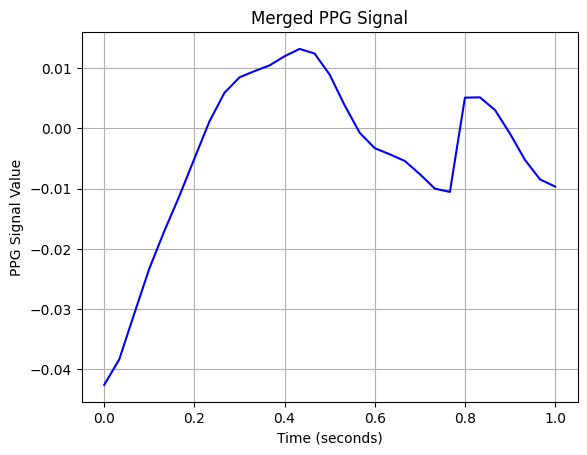

Detected PPG cycles for block 2, 1: [(6, 22, 27, 30, 35)]
Sorted PPG cycles: [(6, 22, 27, 30, 35)]
Selected PPG cycles 2, 1: [(6, 22, 27, 30, 35), (6, 22, 27, 30, 35), (6, 22, 27, 30, 35)]
Merged PPG signal: [-0.03794535 -0.0378289  -0.03257321 -0.02522085 -0.01869503 -0.01427754
 -0.01128085 -0.00799472 -0.00316955  0.00304571  0.0093827   0.0146715
  0.01890869  0.02312096  0.02796414  0.03223566  0.03286254  0.02691165
  0.01438964 -0.00047108 -0.01098261 -0.01209919 -0.00405155  0.00732578
  0.01415642  0.01161239  0.00089831 -0.01198218 -0.02060756 -0.02228634]


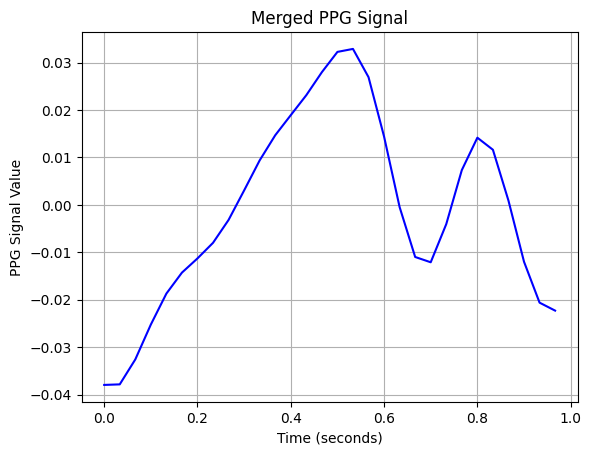

Detected PPG cycles for block 2, 2: [(91, 96, 103, 104, 113), (120, 128, 134, 138, 144)]
Sorted PPG cycles: [(120, 128, 134, 138, 144), (91, 96, 103, 104, 113)]
Selected PPG cycles 2, 2: [(120, 128, 134, 138, 144), (91, 96, 103, 104, 113), (120, 128, 134, 138, 144)]
Merged PPG signal: [-0.01681846 -0.01264284 -0.00463038  0.00441413  0.0117367   0.01611805
  0.01792584  0.01809297  0.0171675   0.0152141   0.01235756  0.00917835
  0.00649123  0.00479477  0.00402001  0.0038058   0.00389245  0.00410682
  0.00396402  0.0025032  -0.00113178 -0.00667265 -0.01228081 -0.00823415
 -0.00873312]


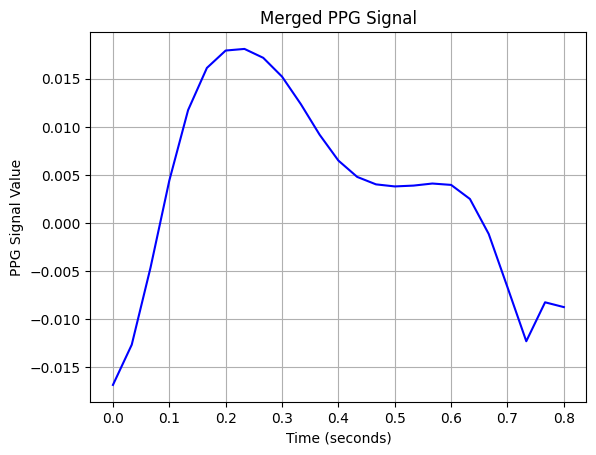

Detected PPG cycles for block 2, 3: [(25, 31, 37, 44, 52), (186, 192, 196, 197, 207)]
Sorted PPG cycles: [(186, 192, 196, 197, 207), (25, 31, 37, 44, 52)]
Selected PPG cycles 2, 3: [(186, 192, 196, 197, 207), (25, 31, 37, 44, 52), (186, 192, 196, 197, 207)]
Merged PPG signal: [-0.0375612  -0.03374274 -0.01424851  0.01912145  0.05523393  0.07970492
  0.08384235  0.06997315  0.04916026  0.03305347  0.02607968  0.02375582
  0.01792974  0.00426047 -0.01431188 -0.03078725 -0.04099959 -0.0480356
 -0.0600056  -0.08244132 -0.11112587 -0.13121209  0.00282451  0.0010237
 -0.00129672 -0.0036959  -0.0055756  -0.00651212]


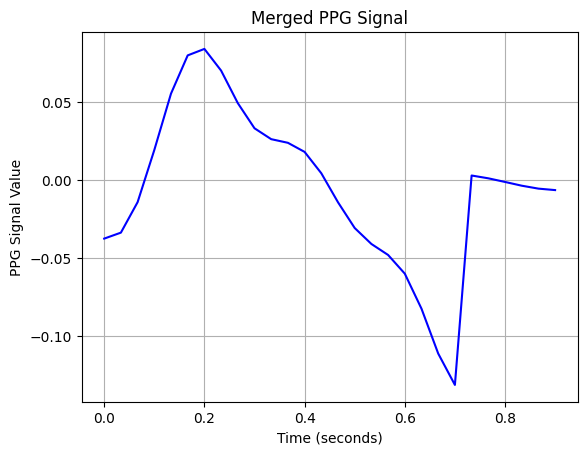

Detected PPG cycles for block 2, 4: [(91, 98, 102, 104, 115)]
Sorted PPG cycles: [(91, 98, 102, 104, 115)]
Selected PPG cycles 2, 4: [(91, 98, 102, 104, 115), (91, 98, 102, 104, 115), (91, 98, 102, 104, 115)]
Merged PPG signal: [-0.04142073 -0.03615416 -0.02541048 -0.01157464  0.00267107  0.01494259
  0.02330884  0.0266476   0.025308    0.0213568   0.0176803   0.01622966
  0.01672877  0.01703394  0.0149756   0.01014542  0.00406769 -0.00137223
 -0.0057739  -0.0106169  -0.01781796 -0.02775172 -0.03851332 -0.04705858
 -0.0511953 ]


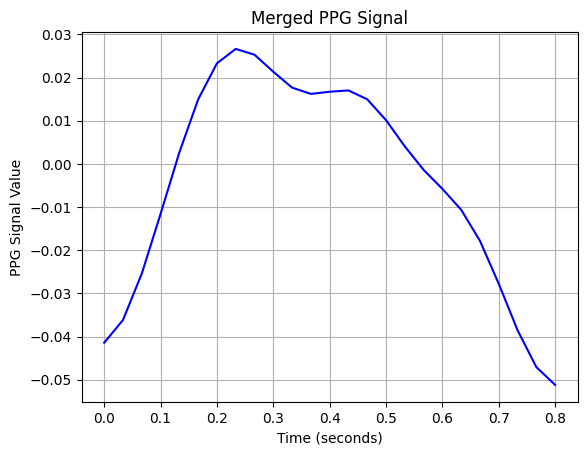

Detected PPG cycles for block 2, 5: []
Sorted PPG cycles: []
Selected PPG cycles 2, 5: []
Merged PPG signal: None
No merged signal to visualize.
Detected PPG cycles for block 2, 6: [(47, 54, 58, 60, 69), (69, 76, 85, 88, 96)]
Sorted PPG cycles: [(69, 76, 85, 88, 96), (47, 54, 58, 60, 69)]
Selected PPG cycles 2, 6: [(69, 76, 85, 88, 96), (47, 54, 58, 60, 69), (69, 76, 85, 88, 96)]
Merged PPG signal: [-0.05196218 -0.04920245 -0.03855716 -0.02033331  0.00152401  0.02093933
  0.03284409  0.03584442  0.03259093  0.02767182  0.02459638  0.02395301
  0.02379827  0.02165324  0.01646086  0.00916694  0.00180511 -0.00395751
 -0.00769272 -0.01006145 -0.0120266  -0.01412811 -0.01623453 -0.00086115
 -0.00403777 -0.00781312 -0.01086531 -0.0113771 ]


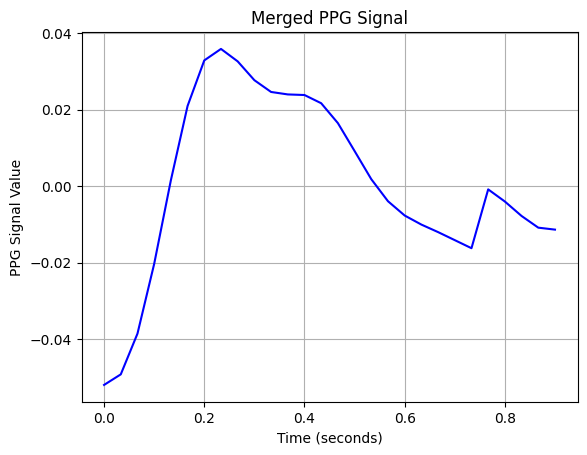

Detected PPG cycles for block 2, 7: [(91, 100, 105, 108, 112), (141, 151, 157, 159, 163)]
Sorted PPG cycles: [(141, 151, 157, 159, 163), (91, 100, 105, 108, 112)]
Selected PPG cycles 2, 7: [(141, 151, 157, 159, 163), (91, 100, 105, 108, 112), (141, 151, 157, 159, 163)]
Merged PPG signal: [-0.0442861  -0.03860238 -0.02324977 -0.00299757  0.01579633  0.02903673
  0.03674461  0.04169691  0.04620647  0.04976979  0.04944849  0.04256413
  0.02946045  0.01410183  0.00197693 -0.00324055 -0.00199706  0.00138174
  0.00133295 -0.00546813 -0.0177947  -0.03006401 -0.02923764]


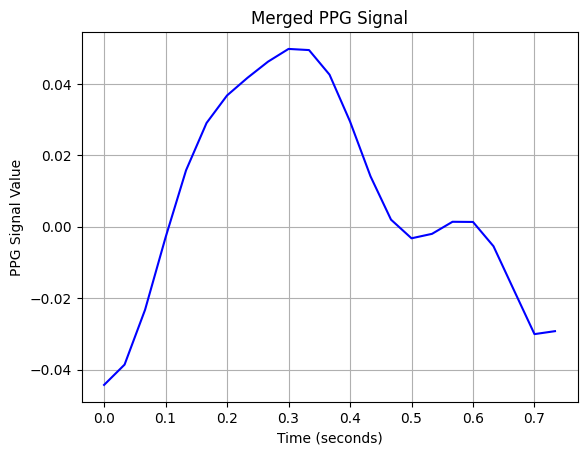

Detected PPG cycles for block 2, 8: [(47, 53, 62, 65, 70)]
Sorted PPG cycles: [(47, 53, 62, 65, 70)]
Selected PPG cycles 2, 8: [(47, 53, 62, 65, 70), (47, 53, 62, 65, 70), (47, 53, 62, 65, 70)]
Merged PPG signal: [-0.1327214  -0.12348448 -0.08573735 -0.02993204  0.02615832  0.06544797
  0.07912307  0.06957101  0.04717784  0.02331536  0.00415939 -0.01082712
 -0.02534    -0.04083883 -0.05376591 -0.0577418  -0.04919838 -0.03205699
 -0.01739564 -0.01744761 -0.03740404 -0.07045163 -0.09979831 -0.10711759]


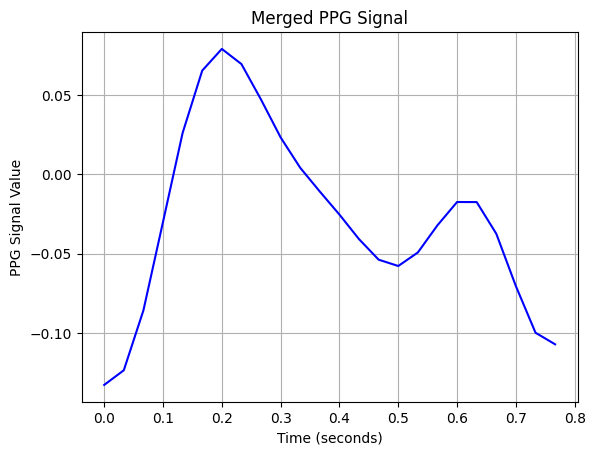

Detected PPG cycles for block 2, 9: [(186, 192, 196, 198, 209)]
Sorted PPG cycles: [(186, 192, 196, 198, 209)]
Selected PPG cycles 2, 9: [(186, 192, 196, 198, 209), (186, 192, 196, 198, 209), (186, 192, 196, 198, 209)]
Merged PPG signal: [-0.11345624 -0.10774431 -0.07917378 -0.03698261  0.00331623  0.0273043
  0.02879476  0.01237162 -0.01022725 -0.02742521 -0.03404769 -0.03277722
 -0.03063644 -0.03357958 -0.04298471 -0.05587917 -0.06796794 -0.07703323
 -0.08463584 -0.09534065 -0.11375229 -0.14027155 -0.16720501 -0.17773763]


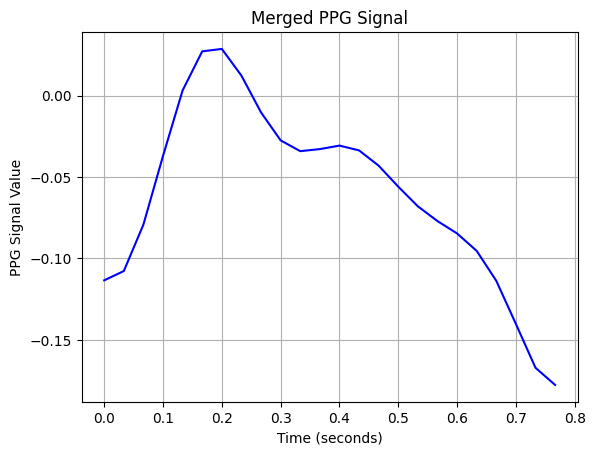

Detected PPG cycles for block 3, 0: []
Sorted PPG cycles: []
Selected PPG cycles 3, 0: []
Merged PPG signal: None
No merged signal to visualize.
Detected PPG cycles for block 3, 1: [(218, 231, 237, 239, 242)]
Sorted PPG cycles: [(218, 231, 237, 239, 242)]
Selected PPG cycles 3, 1: [(218, 231, 237, 239, 242), (218, 231, 237, 239, 242), (218, 231, 237, 239, 242)]
Merged PPG signal: [-0.21289907 -0.20981806 -0.18494162 -0.146582   -0.1021837  -0.05553451
 -0.00776761  0.04082456  0.09052551  0.14251177  0.1970232   0.24900255
  0.28509587  0.28712847  0.2427108   0.15654972  0.05296706 -0.03486072
 -0.08327314 -0.09138297 -0.0791449  -0.07129943 -0.07921674 -0.09435971
 -0.09782664]


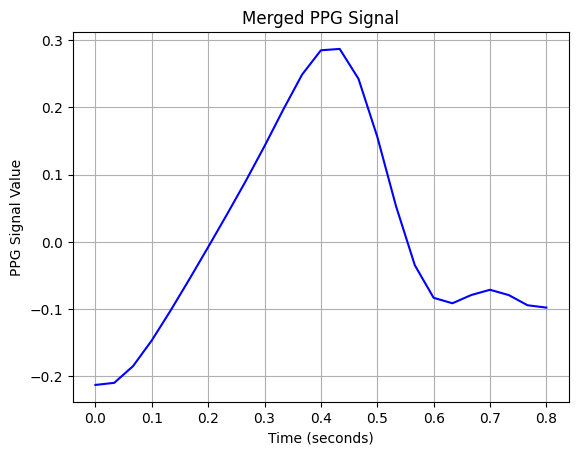

Detected PPG cycles for block 3, 2: []
Sorted PPG cycles: []
Selected PPG cycles 3, 2: []
Merged PPG signal: None
No merged signal to visualize.
Detected PPG cycles for block 3, 3: [(6, 22, 27, 31, 36), (116, 126, 128, 129, 139), (184, 190, 194, 197, 207)]
Sorted PPG cycles: [(184, 190, 194, 197, 207), (116, 126, 128, 129, 139), (6, 22, 27, 31, 36)]
Selected PPG cycles 3, 3: [(184, 190, 194, 197, 207), (116, 126, 128, 129, 139), (6, 22, 27, 31, 36)]
Merged PPG signal: [-0.16524008 -0.15936413 -0.12460576 -0.07320553 -0.02284556  0.01288833
  0.03023248  0.03432853  0.03365708  0.03441372  0.03830371  0.04394181
  0.04947747  0.05398922  0.05704709  0.05765009  0.05401468  0.0445597
  0.02921857  0.01000491 -0.00949221 -0.02521186 -0.03373424 -0.03322662
  0.00754575  0.00775604  0.00515398 -0.00031575 -0.0073364  -0.01360189
 -0.01690173]


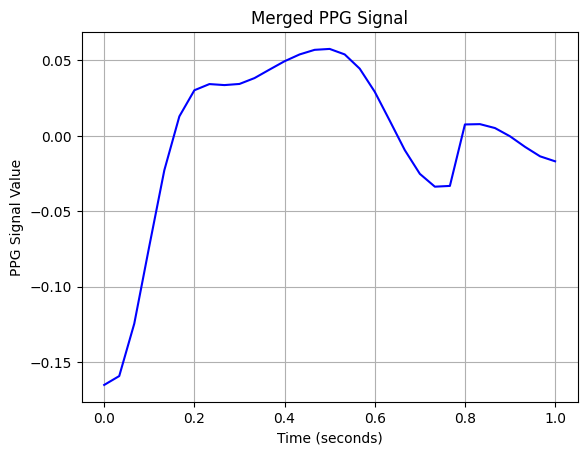

Detected PPG cycles for block 3, 4: [(89, 99, 107, 110, 119), (178, 184, 189, 193, 202)]
Sorted PPG cycles: [(178, 184, 189, 193, 202), (89, 99, 107, 110, 119)]
Selected PPG cycles 3, 4: [(178, 184, 189, 193, 202), (89, 99, 107, 110, 119), (178, 184, 189, 193, 202)]
Merged PPG signal: [-0.04053548 -0.03506765 -0.01831872  0.01003104  0.04398191  0.07268466
  0.08560843  0.07831569  0.05504515  0.0263388   0.00325637 -0.00811763
 -0.00863604 -0.00386372  0.00027367  0.00090933 -0.00118713 -0.00359951
 -0.00493144 -0.00614744 -0.00977178 -0.01765933 -0.02897947 -0.03992495
 -0.04560615 -0.00653026 -0.00757516 -0.00829135 -0.00961267 -0.01151335
 -0.01270103]


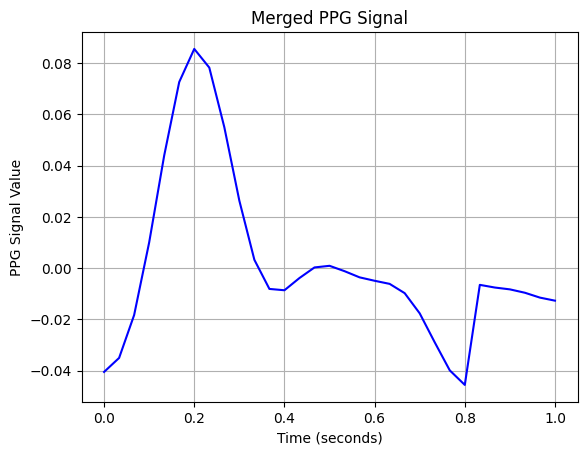

Detected PPG cycles for block 3, 5: [(50, 54, 61, 65, 72), (185, 192, 195, 197, 208)]
Sorted PPG cycles: [(185, 192, 195, 197, 208), (50, 54, 61, 65, 72)]
Selected PPG cycles 3, 5: [(185, 192, 195, 197, 208), (50, 54, 61, 65, 72), (185, 192, 195, 197, 208)]
Merged PPG signal: [-0.07746964 -0.06962312 -0.04691536 -0.01578844  0.01470935  0.03690558
  0.04729033  0.04715022  0.0411585   0.03474164  0.03140612  0.03125162
  0.03145174  0.02847462  0.0206767   0.00948349 -0.00176249 -0.01047351
 -0.0168911  -0.02374066 -0.03349535 -0.04529538 -0.05408033 -0.03892907]


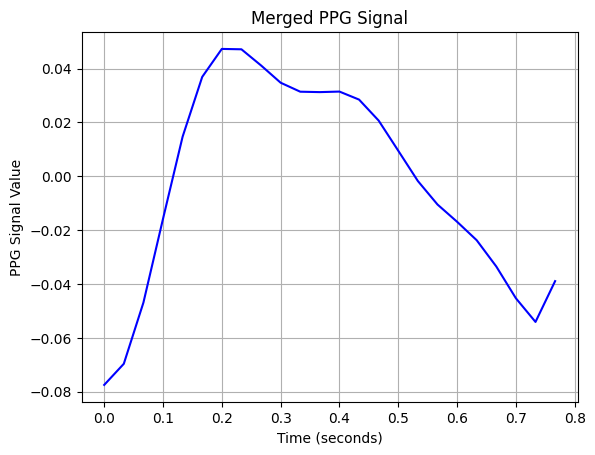

Detected PPG cycles for block 3, 6: []
Sorted PPG cycles: []
Selected PPG cycles 3, 6: []
Merged PPG signal: None
No merged signal to visualize.
Detected PPG cycles for block 3, 7: [(68, 76, 86, 88, 91)]
Sorted PPG cycles: [(68, 76, 86, 88, 91)]
Selected PPG cycles 3, 7: [(68, 76, 86, 88, 91), (68, 76, 86, 88, 91), (68, 76, 86, 88, 91)]
Merged PPG signal: [-0.08783464 -0.08089561 -0.06155895 -0.03452711 -0.00480855  0.02395063
  0.04874074  0.06615946  0.07336236  0.07058721  0.06226835  0.05441687
  0.04966041  0.04444821  0.03182989  0.00824967 -0.02155452 -0.04664702
 -0.05812397 -0.05663436 -0.05213032 -0.05519594 -0.06699448 -0.07680871]


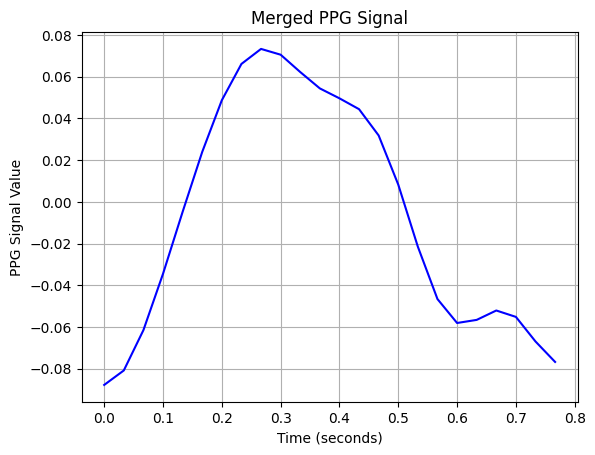

Detected PPG cycles for block 3, 8: [(47, 53, 57, 60, 68), (139, 145, 150, 155, 162)]
Sorted PPG cycles: [(139, 145, 150, 155, 162), (47, 53, 57, 60, 68)]
Selected PPG cycles 3, 8: [(139, 145, 150, 155, 162), (47, 53, 57, 60, 68), (139, 145, 150, 155, 162)]
Merged PPG signal: [-0.07352054 -0.06482991 -0.0456331  -0.02065674  0.00337116  0.02063204
  0.0284402   0.02765271  0.02147324  0.01374023  0.00764521  0.00507449
  0.00627731  0.00974321  0.01259274  0.01173636  0.00539443 -0.00603061
 -0.02047351 -0.03572418 -0.0505354  -0.0641299  -0.04293977 -0.04902362]


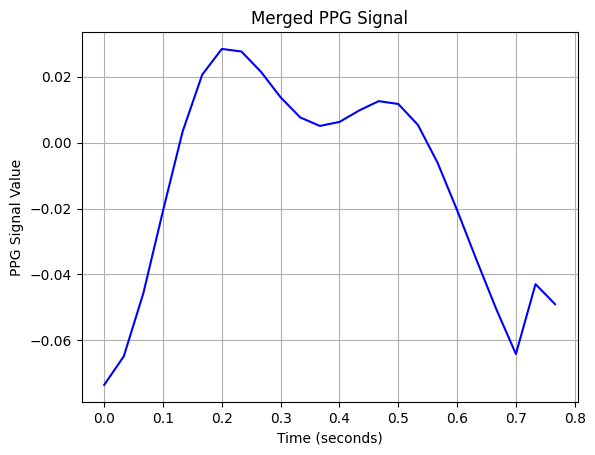

Detected PPG cycles for block 3, 9: [(46, 57, 62, 66, 71), (120, 126, 130, 131, 143)]
Sorted PPG cycles: [(120, 126, 130, 131, 143), (46, 57, 62, 66, 71)]
Selected PPG cycles 3, 9: [(120, 126, 130, 131, 143), (46, 57, 62, 66, 71), (120, 126, 130, 131, 143)]
Merged PPG signal: [-3.59883371e-02 -3.04615435e-02 -1.58388612e-02  5.13112446e-03
  2.63201001e-02  4.13794302e-02  4.73185975e-02  4.59992215e-02
  4.24077157e-02  4.09307656e-02  4.23663411e-02  4.38165028e-02
  4.13679210e-02  3.33618169e-02  2.17405177e-02  1.05938178e-02
  3.21281915e-03 -4.42361813e-05 -1.60892642e-03 -4.64330678e-03
 -1.07403797e-02 -1.89815163e-02 -2.67836620e-02 -3.17473523e-02
 -5.92106782e-03 -6.69680332e-03]


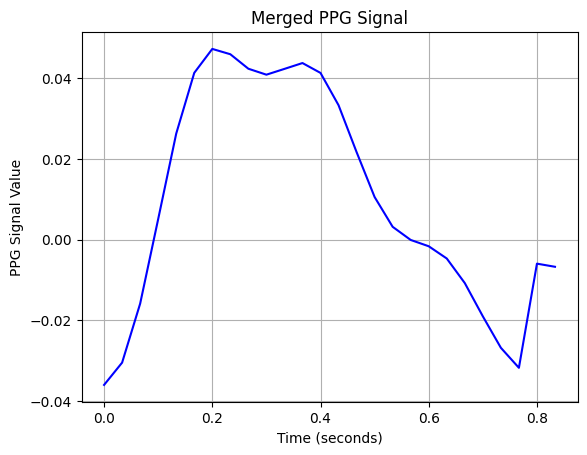

Detected PPG cycles for block 4, 0: [(42, 51, 57, 61, 65), (138, 146, 156, 158, 163), (186, 192, 201, 203, 209)]
Sorted PPG cycles: [(186, 192, 201, 203, 209), (138, 146, 156, 158, 163), (42, 51, 57, 61, 65)]
Selected PPG cycles 4, 0: [(186, 192, 201, 203, 209), (138, 146, 156, 158, 163), (42, 51, 57, 61, 65)]
Merged PPG signal: [-0.04308525 -0.03927992 -0.02852977 -0.01308013  0.00297047  0.0158511
  0.02372037  0.02681121  0.02646112  0.02405356  0.02059006  0.01681474
  0.01336672  0.01067575  0.00880697  0.00756203  0.0067509   0.00620558
  0.0053573   0.00288535 -0.00274194 -0.01168168 -0.02118885 -0.02585625
 -0.01132569 -0.01221799]


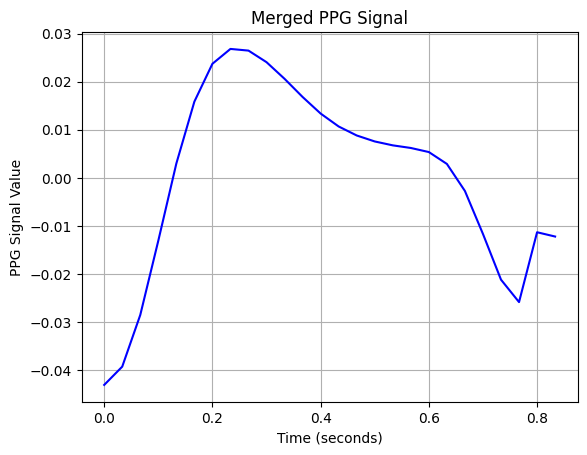

Detected PPG cycles for block 4, 1: [(27, 43, 46, 47, 53), (114, 124, 127, 129, 138), (138, 145, 148, 151, 161), (185, 191, 194, 196, 207)]
Sorted PPG cycles: [(185, 191, 194, 196, 207), (138, 145, 148, 151, 161), (114, 124, 127, 129, 138), (27, 43, 46, 47, 53)]
Selected PPG cycles 4, 1: [(185, 191, 194, 196, 207), (138, 145, 148, 151, 161), (114, 124, 127, 129, 138)]
Merged PPG signal: [-0.09407851 -0.08063947 -0.05482891 -0.02240237  0.00917687  0.03332033
  0.04669381  0.05021347  0.04800171  0.04479333  0.0433217   0.04329371
  0.04247159  0.03886216  0.03224793  0.02392596  0.01506451  0.00527759
 -0.00715297 -0.02339015 -0.04195757 -0.058243   -0.06624531 -0.04281076
 -0.02709804]


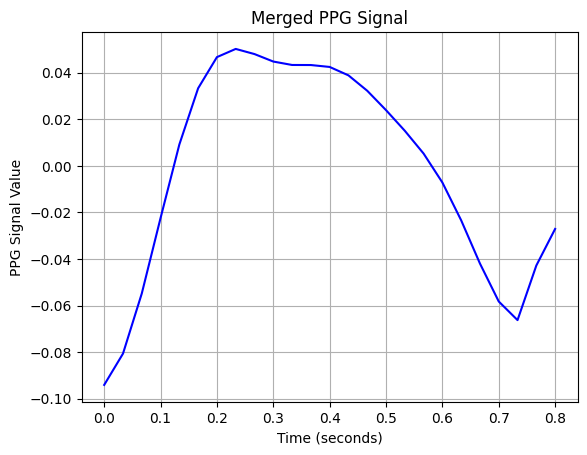

Detected PPG cycles for block 4, 2: [(48, 53, 57, 59, 69), (139, 146, 156, 158, 162)]
Sorted PPG cycles: [(139, 146, 156, 158, 162), (48, 53, 57, 59, 69)]
Selected PPG cycles 4, 2: [(139, 146, 156, 158, 162), (48, 53, 57, 59, 69), (139, 146, 156, 158, 162)]
Merged PPG signal: [-0.03852609 -0.03433886 -0.02157489 -0.00164551  0.02029842  0.03758472
  0.04540211  0.04329754  0.03519548  0.02685472  0.02231258  0.02157553
  0.0210699   0.01655694  0.00649734 -0.0065585  -0.01766485 -0.02314198
 -0.02352447 -0.02345396 -0.02831037 -0.03982518 -0.04885816 -0.05787948]


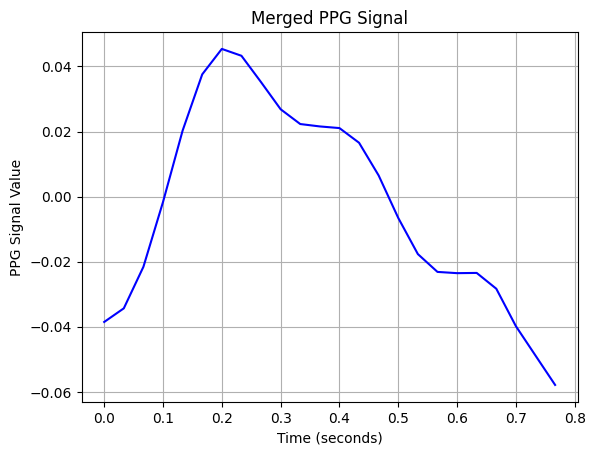

Detected PPG cycles for block 4, 3: [(47, 52, 57, 58, 70), (90, 99, 103, 106, 115)]
Sorted PPG cycles: [(90, 99, 103, 106, 115), (47, 52, 57, 58, 70)]
Selected PPG cycles 4, 3: [(90, 99, 103, 106, 115), (47, 52, 57, 58, 70), (90, 99, 103, 106, 115)]
Merged PPG signal: [-0.03287654 -0.02933833 -0.01465492  0.00515969  0.02256809  0.03285779
  0.03591243  0.03477446  0.03274553  0.03137677  0.03042272  0.02908706
  0.0271584   0.02520975  0.02404154  0.02400835  0.02462307  0.02445558
  0.02132775  0.012994   -0.00164117 -0.02130643 -0.04214777 -0.05913054
 -0.05510418 -0.05986979]


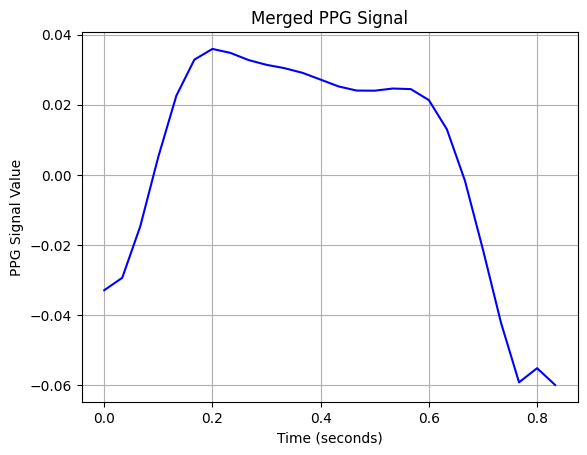

Detected PPG cycles for block 4, 4: [(136, 146, 148, 150, 162), (185, 192, 202, 203, 208)]
Sorted PPG cycles: [(185, 192, 202, 203, 208), (136, 146, 148, 150, 162)]
Selected PPG cycles 4, 4: [(185, 192, 202, 203, 208), (136, 146, 148, 150, 162), (185, 192, 202, 203, 208)]
Merged PPG signal: [-0.09628976 -0.08586487 -0.06221314 -0.02934354  0.0057644   0.0352806
  0.05342716  0.05885587  0.0549775   0.04772641  0.04199111  0.03905515
  0.03678664  0.03227743  0.02474578  0.01634901  0.01029128  0.00784369
  0.00679895  0.00275947 -0.00753849 -0.02318842 -0.03847455 -0.04512967
 -0.00376226 -0.00745538 -0.01001399]


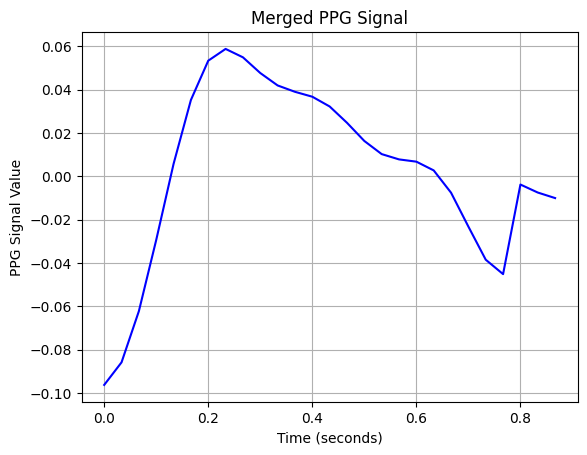

Detected PPG cycles for block 4, 5: [(47, 53, 57, 59, 68), (90, 101, 104, 107, 113), (214, 224, 228, 230, 237)]
Sorted PPG cycles: [(214, 224, 228, 230, 237), (90, 101, 104, 107, 113), (47, 53, 57, 59, 68)]
Selected PPG cycles 4, 5: [(214, 224, 228, 230, 237), (90, 101, 104, 107, 113), (47, 53, 57, 59, 68)]
Merged PPG signal: [-0.07583819 -0.07099462 -0.05858833 -0.04142756 -0.02243906 -0.00416877
  0.0114502   0.02324539  0.03091723  0.03498189  0.03643887  0.03629289
  0.03523067  0.03361977  0.03165605  0.02931875  0.02605236  0.02057598
  0.01137679 -0.00205697 -0.0180439  -0.03270352 -0.02282265 -0.02669156]


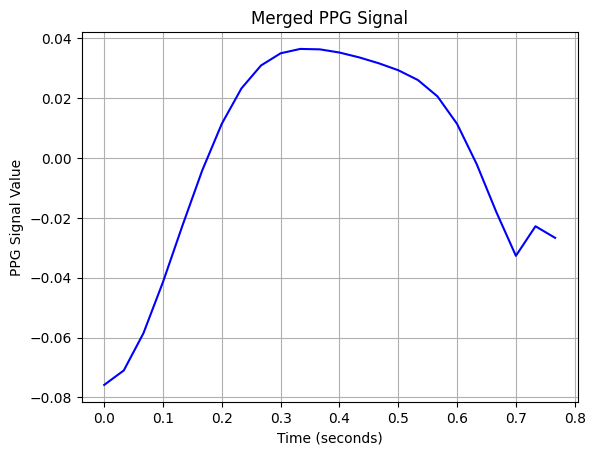

Detected PPG cycles for block 4, 6: [(20, 31, 36, 43, 50), (186, 192, 195, 197, 208)]
Sorted PPG cycles: [(186, 192, 195, 197, 208), (20, 31, 36, 43, 50)]
Selected PPG cycles 4, 6: [(186, 192, 195, 197, 208), (20, 31, 36, 43, 50), (186, 192, 195, 197, 208)]
Merged PPG signal: [-0.09352351 -0.07852695 -0.04294448  0.00492315  0.05067678  0.08127108
  0.09179935  0.08740669  0.07915726  0.07651519  0.08123553  0.08651942
  0.08189377  0.0606038   0.02467189 -0.01579215 -0.04878991 -0.06822979
 -0.07801278 -0.08905525 -0.11031228 -0.13921903 -0.15839227  0.00829338
  0.00765558  0.00572194  0.00267985 -0.00084076 -0.00407185 -0.00641308
 -0.00752888]


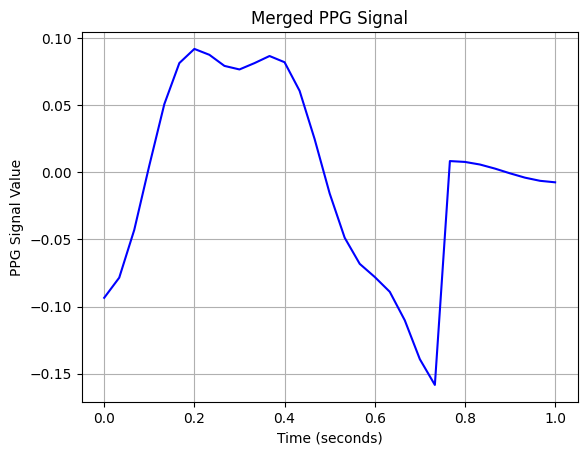

Detected PPG cycles for block 4, 7: [(21, 28, 31, 35, 47), (115, 126, 128, 129, 139), (185, 191, 195, 197, 208)]
Sorted PPG cycles: [(185, 191, 195, 197, 208), (115, 126, 128, 129, 139), (21, 28, 31, 35, 47)]
Selected PPG cycles 4, 7: [(185, 191, 195, 197, 208), (115, 126, 128, 129, 139), (21, 28, 31, 35, 47)]
Merged PPG signal: [-0.25801777 -0.23341811 -0.17189349 -0.08918256 -0.00651572  0.058547
  0.09814674  0.11477371  0.1174394   0.11614619  0.11741369  0.12238239
  0.12758238  0.12747195  0.11742424  0.09585662  0.06461808  0.02756552
 -0.01174701 -0.05168824 -0.09214005 -0.13197157 -0.1659795  -0.1838519
 -0.09984767 -0.04153783 -0.04245483]


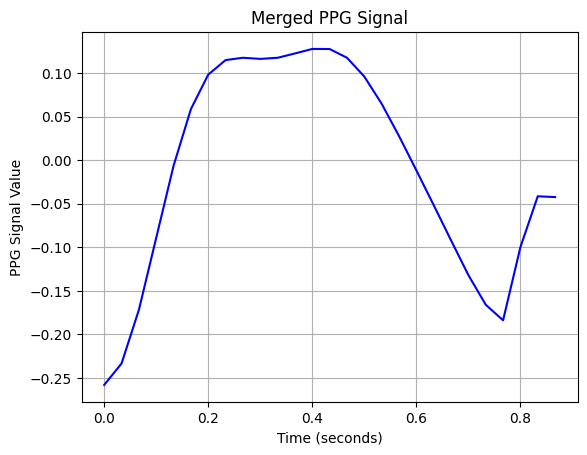

Detected PPG cycles for block 4, 8: [(47, 56, 62, 65, 70)]
Sorted PPG cycles: [(47, 56, 62, 65, 70)]
Selected PPG cycles 4, 8: [(47, 56, 62, 65, 70), (47, 56, 62, 65, 70), (47, 56, 62, 65, 70)]
Merged PPG signal: [-0.06072859 -0.06047937 -0.05303651 -0.04037425 -0.02472554 -0.00846296
  0.00598205  0.01664438  0.02274296  0.0248626   0.02425051  0.02177813
  0.01757978  0.01179796  0.00568105  0.00166247  0.00178886  0.00549828
  0.00881421  0.00632086 -0.00490806 -0.02221892 -0.03783827 -0.04319662]


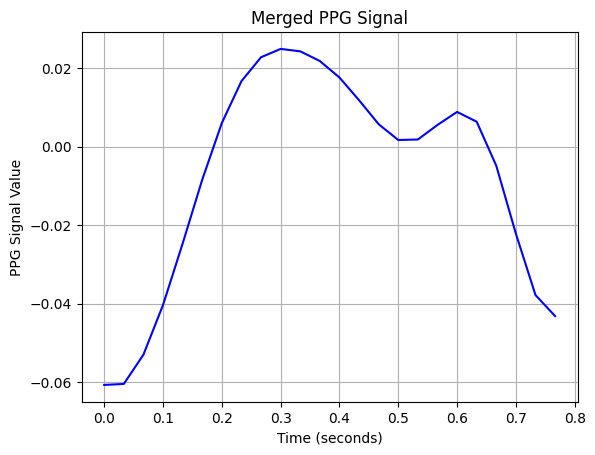

Detected PPG cycles for block 4, 9: []
Sorted PPG cycles: []
Selected PPG cycles 4, 9: []
Merged PPG signal: None
No merged signal to visualize.
Detected PPG cycles for block 5, 0: [(68, 75, 80, 82, 89), (163, 168, 171, 173, 185), (185, 193, 195, 197, 207)]
Sorted PPG cycles: [(185, 193, 195, 197, 207), (163, 168, 171, 173, 185), (68, 75, 80, 82, 89)]
Selected PPG cycles 5, 0: [(185, 193, 195, 197, 207), (163, 168, 171, 173, 185), (68, 75, 80, 82, 89)]
Merged PPG signal: [-0.0363187  -0.03522441 -0.02681939 -0.01268265  0.00356388  0.01772689
  0.02673867  0.02978326  0.02831493  0.02499198  0.02213193  0.02055953
  0.01947332  0.01731796  0.01301324  0.00668598 -0.00056549 -0.00762318
 -0.01421909 -0.02096271 -0.02839773 -0.03575065 -0.04113055]


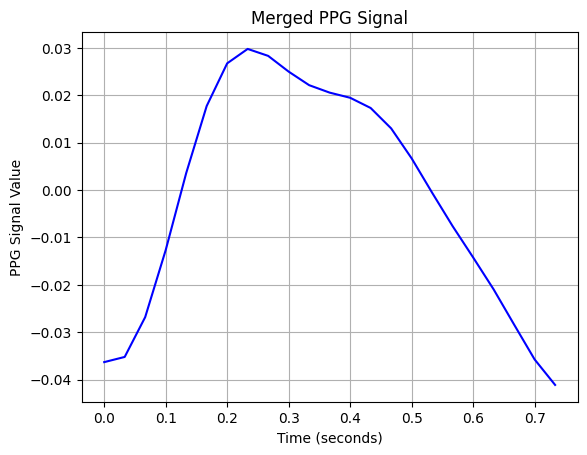

Detected PPG cycles for block 5, 1: [(48, 53, 58, 64, 70), (70, 76, 80, 83, 91), (161, 167, 169, 171, 185), (185, 191, 195, 197, 207)]
Sorted PPG cycles: [(185, 191, 195, 197, 207), (161, 167, 169, 171, 185), (70, 76, 80, 83, 91), (48, 53, 58, 64, 70)]
Selected PPG cycles 5, 1: [(185, 191, 195, 197, 207), (161, 167, 169, 171, 185), (70, 76, 80, 83, 91)]
Merged PPG signal: [-0.06391749 -0.05695738 -0.03679161 -0.00734783  0.02259949  0.0439719
  0.05229797  0.04974738  0.04298464  0.03844512  0.03835878  0.04012004
  0.03903863  0.03210217  0.0199262   0.00575223 -0.00729493 -0.01833086
 -0.02866207 -0.03990039 -0.05193244 -0.06227839 -0.06479365 -0.03309497
 -0.03483285]


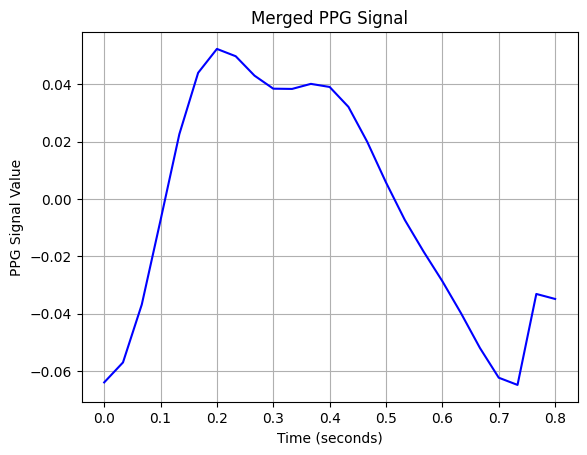

Detected PPG cycles for block 5, 2: [(48, 53, 61, 65, 69), (161, 168, 170, 172, 185)]
Sorted PPG cycles: [(161, 168, 170, 172, 185), (48, 53, 61, 65, 69)]
Selected PPG cycles 5, 2: [(161, 168, 170, 172, 185), (48, 53, 61, 65, 69), (161, 168, 170, 172, 185)]
Merged PPG signal: [-0.06411577 -0.06075418 -0.04183337 -0.01226543  0.01814278  0.03998859
  0.04906906  0.04776771  0.04247214  0.03899877  0.03906602  0.0398935
  0.03681776  0.02691358  0.01116153 -0.0061607  -0.02032183 -0.02928388
 -0.03509243 -0.04256374 -0.0559657  -0.07562063 -0.09016411 -0.10894396
 -0.11244243]


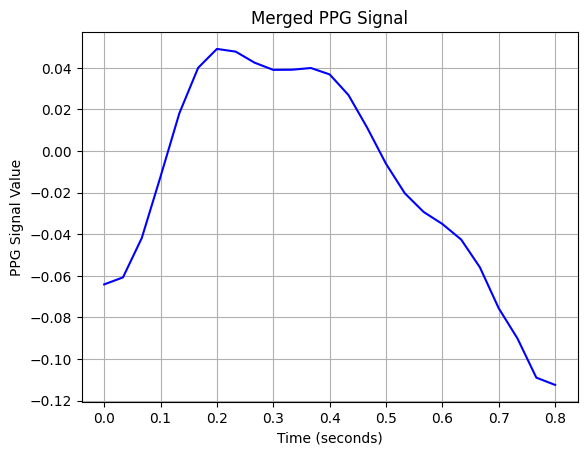

Detected PPG cycles for block 5, 3: [(90, 101, 105, 107, 115), (215, 223, 228, 231, 236)]
Sorted PPG cycles: [(215, 223, 228, 231, 236), (90, 101, 105, 107, 115)]
Selected PPG cycles 5, 3: [(215, 223, 228, 231, 236), (90, 101, 105, 107, 115), (215, 223, 228, 231, 236)]
Merged PPG signal: [-0.06709587 -0.06460054 -0.05327902 -0.0332042  -0.00907495  0.01261104
  0.02744533  0.03486094  0.03680316  0.03520123  0.03087274  0.02461698
  0.01874369  0.01669961  0.02043521  0.02777302  0.03263799  0.0287643
  0.01430782 -0.00638359 -0.025497   -0.0369508  -0.01403406 -0.02169358
 -0.02689317 -0.02877429]


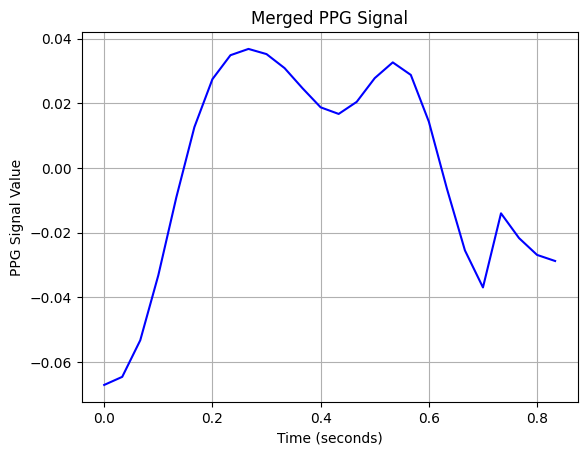

Detected PPG cycles for block 5, 4: [(72, 81, 89, 92, 96), (142, 151, 156, 159, 165)]
Sorted PPG cycles: [(142, 151, 156, 159, 165), (72, 81, 89, 92, 96)]
Selected PPG cycles 5, 4: [(142, 151, 156, 159, 165), (72, 81, 89, 92, 96), (142, 151, 156, 159, 165)]
Merged PPG signal: [-0.01428092 -0.01230583 -0.00540011  0.00376217  0.01180142  0.01674758
  0.01904555  0.02064295  0.02288531  0.02500266  0.02457323  0.01971132
  0.01118153  0.00254545 -0.00202586 -0.00071106  0.00451051  0.00907548
  0.00883124  0.00261401 -0.00733529 -0.01712496 -0.02360144 -0.02567985
 -0.0011511 ]


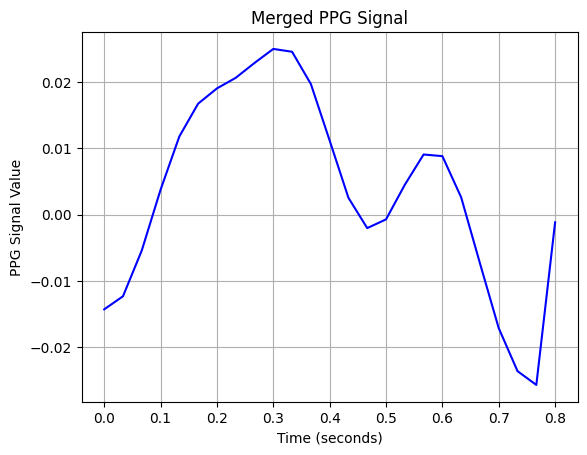

Detected PPG cycles for block 5, 5: [(136, 151, 156, 158, 162)]
Sorted PPG cycles: [(136, 151, 156, 158, 162)]
Selected PPG cycles 5, 5: [(136, 151, 156, 158, 162), (136, 151, 156, 158, 162), (136, 151, 156, 158, 162)]
Merged PPG signal: [-7.18974495e-02 -6.27658781e-02 -5.01091824e-02 -4.07751632e-02
 -3.60609918e-02 -3.18754957e-02 -2.29713830e-02 -7.68477054e-03
  1.05374251e-02  2.57932260e-02  3.41865580e-02  3.64354379e-02
  3.66564336e-02  3.85159274e-02  4.19980132e-02  4.34223077e-02
  3.86575310e-02  2.69084354e-02  1.19995996e-02  2.55377717e-05
 -4.96144096e-03 -4.01654675e-03 -2.74720984e-03 -7.32647932e-03
 -1.97137049e-02 -3.53640945e-02 -4.51405151e-02]


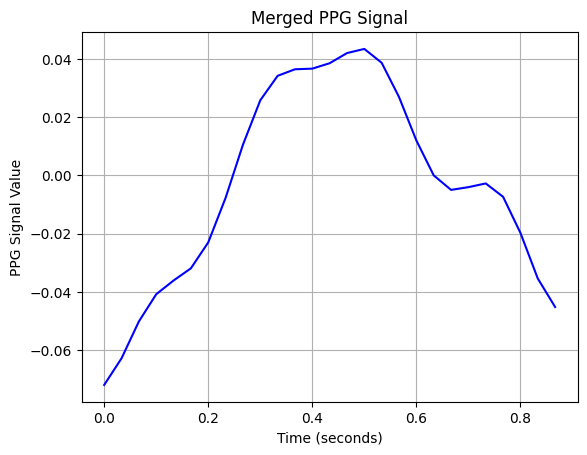

Detected PPG cycles for block 5, 6: [(47, 52, 56, 59, 68), (162, 168, 172, 173, 185), (185, 191, 194, 197, 207)]
Sorted PPG cycles: [(185, 191, 194, 197, 207), (162, 168, 172, 173, 185), (47, 52, 56, 59, 68)]
Selected PPG cycles 5, 6: [(185, 191, 194, 197, 207), (162, 168, 172, 173, 185), (47, 52, 56, 59, 68)]
Merged PPG signal: [-0.19556909 -0.1654573  -0.09670295 -0.00914942  0.07009611  0.11880253
  0.12958383  0.11239888  0.08781612  0.07448476  0.07820437  0.08961097
  0.09215042  0.07481678  0.04034415  0.00254691 -0.02533625 -0.0421585
 -0.06062493 -0.09688864 -0.15519903 -0.2193455  -0.21137119 -0.13663   ]


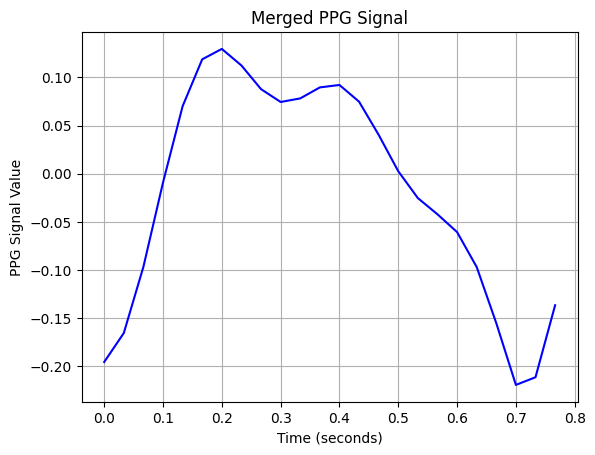

Detected PPG cycles for block 5, 7: [(47, 52, 58, 62, 68), (68, 75, 78, 80, 87), (140, 148, 152, 155, 162), (162, 167, 172, 174, 185)]
Sorted PPG cycles: [(162, 167, 172, 174, 185), (140, 148, 152, 155, 162), (68, 75, 78, 80, 87), (47, 52, 58, 62, 68)]
Selected PPG cycles 5, 7: [(162, 167, 172, 174, 185), (140, 148, 152, 155, 162), (68, 75, 78, 80, 87)]
Merged PPG signal: [-0.05722449 -0.04900191 -0.03080031 -0.00662994  0.01751901  0.0356286
  0.04401624  0.04295494  0.03643623  0.02989729  0.02708855  0.02802681
  0.0294157   0.02724737  0.01970163  0.00819721 -0.00415622 -0.01539868
 -0.0264293  -0.03995346 -0.0429625  -0.0614591  -0.07409204 -0.06277524]


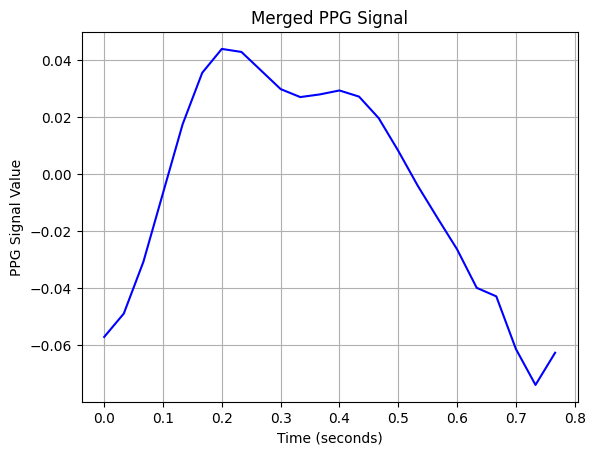

Detected PPG cycles for block 5, 8: []
Sorted PPG cycles: []
Selected PPG cycles 5, 8: []
Merged PPG signal: None
No merged signal to visualize.
Detected PPG cycles for block 5, 9: [(47, 54, 64, 65, 69)]
Sorted PPG cycles: [(47, 54, 64, 65, 69)]
Selected PPG cycles 5, 9: [(47, 54, 64, 65, 69), (47, 54, 64, 65, 69), (47, 54, 64, 65, 69)]
Merged PPG signal: [-0.08562121 -0.08051695 -0.05780438 -0.02162759  0.01969967  0.05604467
  0.0789808   0.08509191  0.07706534  0.06151295  0.044667    0.02889404
  0.01260981 -0.00641921 -0.02728052 -0.04517519 -0.05486849 -0.05574955
 -0.05400387 -0.05918115 -0.07683758 -0.10255017 -0.12235993]


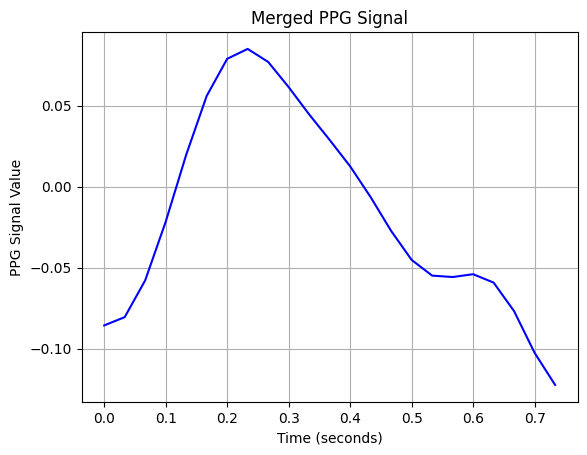

Detected PPG cycles for block 6, 0: [(71, 76, 80, 81, 90), (137, 147, 156, 159, 163), (163, 168, 172, 174, 187)]
Sorted PPG cycles: [(163, 168, 172, 174, 187), (137, 147, 156, 159, 163), (71, 76, 80, 81, 90)]
Selected PPG cycles 6, 0: [(163, 168, 172, 174, 187), (137, 147, 156, 159, 163), (71, 76, 80, 81, 90)]
Merged PPG signal: [-0.02380563 -0.0212784  -0.01304736 -0.00309213  0.00429634  0.00728655
  0.00724276  0.00705885  0.00862634  0.01150937  0.01370704  0.01358
  0.01116883  0.00787764  0.00505042  0.00288928  0.00067965 -0.00205581
 -0.0047485  -0.00621038 -0.00491304 -0.00469613 -0.00564629 -0.00843543
 -0.01204676 -0.0075924  -0.01079462]


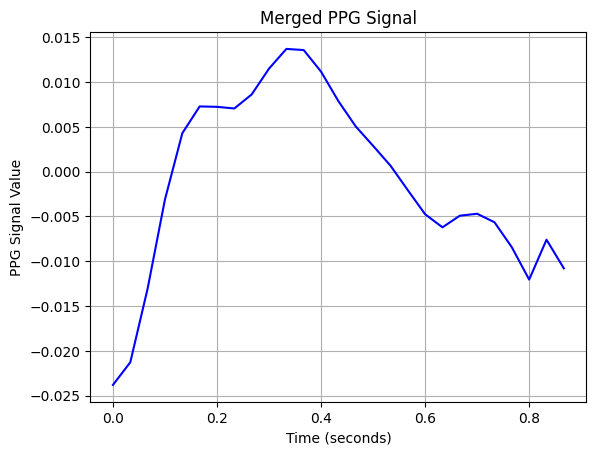

Detected PPG cycles for block 6, 1: [(25, 31, 37, 41, 47), (186, 193, 196, 198, 209)]
Sorted PPG cycles: [(186, 193, 196, 198, 209), (25, 31, 37, 41, 47)]
Selected PPG cycles 6, 1: [(186, 193, 196, 198, 209), (25, 31, 37, 41, 47), (186, 193, 196, 198, 209)]
Merged PPG signal: [-0.04518876 -0.03874599 -0.02426306 -0.00600402  0.01111767  0.0233072
  0.02878392  0.0278326   0.02238707  0.01536491  0.00970501  0.00715779
  0.00734052  0.00784826  0.00575081 -0.00027846 -0.00878102 -0.01647848
 -0.02095943 -0.02296916 -0.02599875 -0.03276963 -0.04099187 -0.03879641]


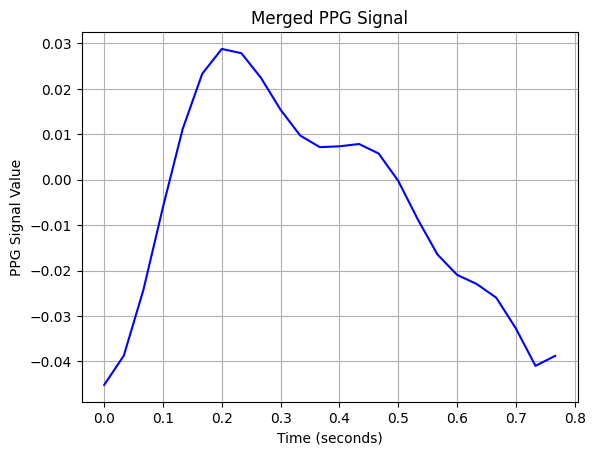

Detected PPG cycles for block 6, 2: [(49, 53, 57, 59, 68), (137, 147, 155, 156, 162)]
Sorted PPG cycles: [(137, 147, 155, 156, 162), (49, 53, 57, 59, 68)]
Selected PPG cycles 6, 2: [(137, 147, 155, 156, 162), (49, 53, 57, 59, 68), (137, 147, 155, 156, 162)]
Merged PPG signal: [-0.04213281 -0.03818616 -0.03101289 -0.02496253 -0.02106478 -0.01725688
 -0.01099877 -0.00189649  0.00780397  0.01500518  0.01806213  0.01761488
  0.01548152  0.0129049   0.00985077  0.00584469  0.00125811 -0.00246547
 -0.00404577 -0.00392523  0.00363894 -0.00172044 -0.01136048 -0.02270365
 -0.03143359 -0.03368419]


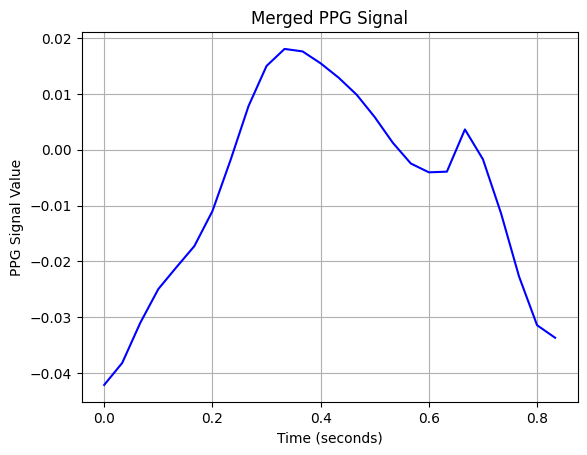

Detected PPG cycles for block 6, 3: [(26, 36, 39, 41, 49), (69, 74, 79, 81, 91), (91, 97, 100, 101, 115)]
Sorted PPG cycles: [(91, 97, 100, 101, 115), (69, 74, 79, 81, 91), (26, 36, 39, 41, 49)]
Selected PPG cycles 6, 3: [(91, 97, 100, 101, 115), (69, 74, 79, 81, 91), (26, 36, 39, 41, 49)]
Merged PPG signal: [-0.05196053 -0.04070929 -0.01644196  0.0115771   0.03334746  0.04384538
  0.04465176  0.04116553  0.03825295  0.03763455  0.03821574  0.03811261
  0.03632162  0.03300455  0.02880752  0.02414471  0.01887206  0.01219863
  0.00275327 -0.01086414 -0.02880721 -0.04857931 -0.06484817 -0.0514678
 -0.04252951]


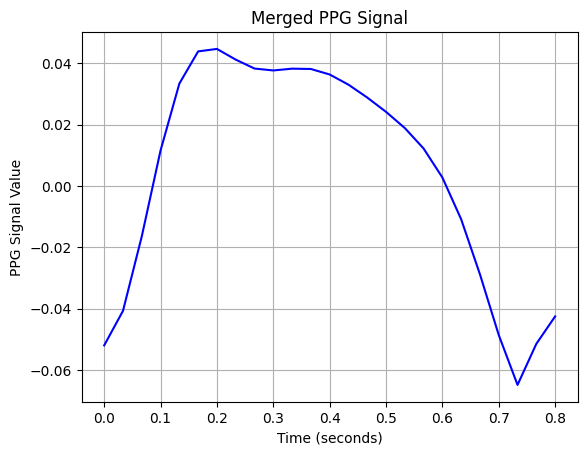

Detected PPG cycles for block 6, 4: [(91, 96, 101, 102, 116), (162, 168, 171, 174, 184)]
Sorted PPG cycles: [(162, 168, 171, 174, 184), (91, 96, 101, 102, 116)]
Selected PPG cycles 6, 4: [(162, 168, 171, 174, 184), (91, 96, 101, 102, 116), (162, 168, 171, 174, 184)]
Merged PPG signal: [-0.10852221 -0.08805557 -0.04426386  0.01270818  0.06686201  0.10343526
  0.11595946  0.10916841  0.09563716  0.08780981  0.09026757  0.0972845
  0.09737613  0.08173723  0.05060236  0.0129063  -0.02056919 -0.0454916
 -0.06732592 -0.09674234 -0.13991792 -0.1906491  -0.2304731  -0.03176605
 -0.03956855 -0.04050119]


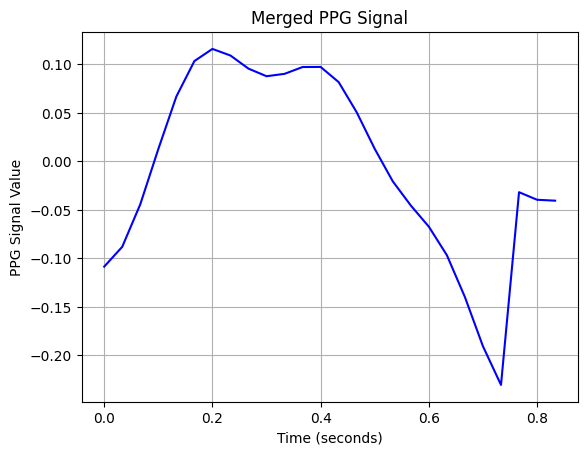

Detected PPG cycles for block 6, 5: [(1, 5, 8, 11, 22), (22, 29, 32, 34, 46), (69, 75, 83, 86, 91), (139, 145, 148, 151, 162), (162, 168, 171, 173, 184), (184, 190, 194, 196, 207)]
Sorted PPG cycles: [(184, 190, 194, 196, 207), (162, 168, 171, 173, 184), (139, 145, 148, 151, 162), (69, 75, 83, 86, 91), (22, 29, 32, 34, 46), (1, 5, 8, 11, 22)]
Selected PPG cycles 6, 5: [(184, 190, 194, 196, 207), (162, 168, 171, 173, 184), (139, 145, 148, 151, 162)]
Merged PPG signal: [-0.13196622 -0.11535097 -0.07533853 -0.02255276  0.02683125  0.05887285
  0.06855174  0.0613302   0.04877264  0.04115825  0.04180411  0.04645085
  0.0475519   0.04010177  0.02490244  0.00727075 -0.00747661 -0.01823452
 -0.0288868  -0.04506615 -0.06913938 -0.09685207 -0.11796441 -0.06408881]


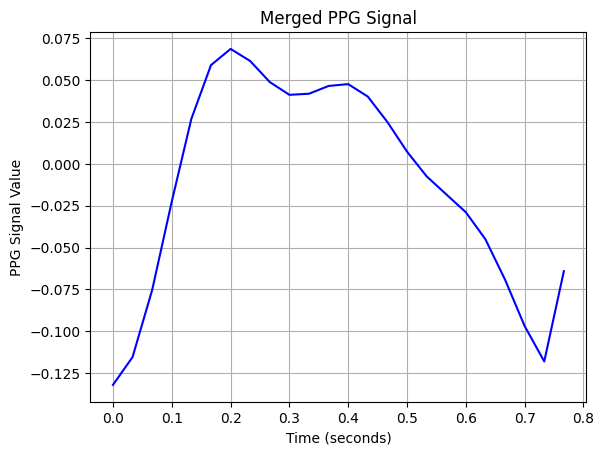

Detected PPG cycles for block 6, 6: [(2, 5, 9, 11, 21), (139, 146, 149, 150, 162)]
Sorted PPG cycles: [(139, 146, 149, 150, 162), (2, 5, 9, 11, 21)]
Selected PPG cycles 6, 6: [(139, 146, 149, 150, 162), (2, 5, 9, 11, 21), (139, 146, 149, 150, 162)]
Merged PPG signal: [-0.03863852 -0.03494526 -0.02756536 -0.01926084 -0.01174722 -0.00577583
 -0.00169086  0.00031912  0.00047018 -0.00039763 -0.00122485 -0.00165118
 -0.00259117 -0.00568373 -0.01182554 -0.02004209 -0.02794752 -0.03375218
 -0.03819607 -0.04440053 -0.03447442 -0.04962073 -0.0630417  -0.06558153]


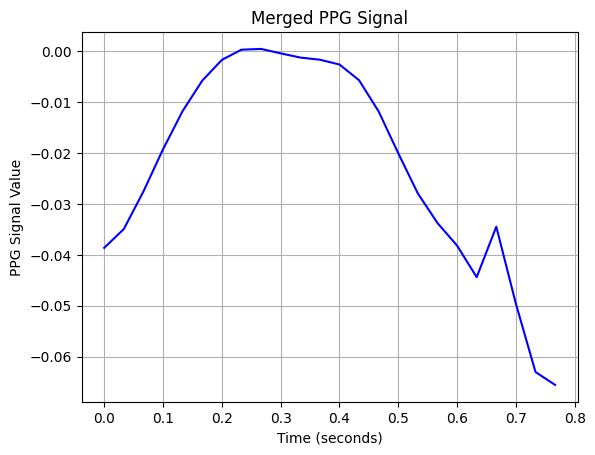

Detected PPG cycles for block 6, 7: []
Sorted PPG cycles: []
Selected PPG cycles 6, 7: []
Merged PPG signal: None
No merged signal to visualize.
Detected PPG cycles for block 6, 8: [(139, 146, 152, 155, 161)]
Sorted PPG cycles: [(139, 146, 152, 155, 161)]
Selected PPG cycles 6, 8: [(139, 146, 152, 155, 161), (139, 146, 152, 155, 161), (139, 146, 152, 155, 161)]
Merged PPG signal: [-0.1158273  -0.11433151 -0.09697978 -0.06736633 -0.03214662  0.0007447
  0.02436654  0.03480776  0.03221946  0.02037966  0.00495268 -0.00874649
 -0.01743388 -0.02033157 -0.01858559 -0.0144054  -0.01065154 -0.01087485
 -0.01901862 -0.03791343 -0.06663127 -0.09817333 -0.11969781]


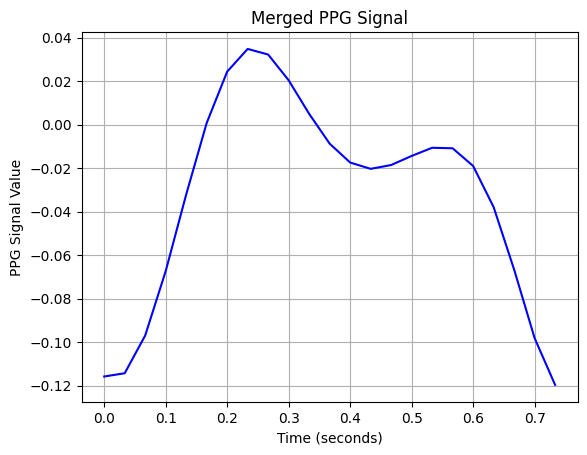

Detected PPG cycles for block 6, 9: [(140, 146, 151, 155, 162)]
Sorted PPG cycles: [(140, 146, 151, 155, 162)]
Selected PPG cycles 6, 9: [(140, 146, 151, 155, 162), (140, 146, 151, 155, 162), (140, 146, 151, 155, 162)]
Merged PPG signal: [-0.07379027 -0.07091959 -0.05704181 -0.0339542  -0.00801365  0.01236031
  0.02075038  0.0158804   0.00196671 -0.0137825  -0.02490227 -0.02848613
 -0.02571673 -0.0202415  -0.01577967 -0.01463235 -0.01791475 -0.02685732
 -0.04344473 -0.06892593 -0.10046955 -0.12838943 -0.13713663]


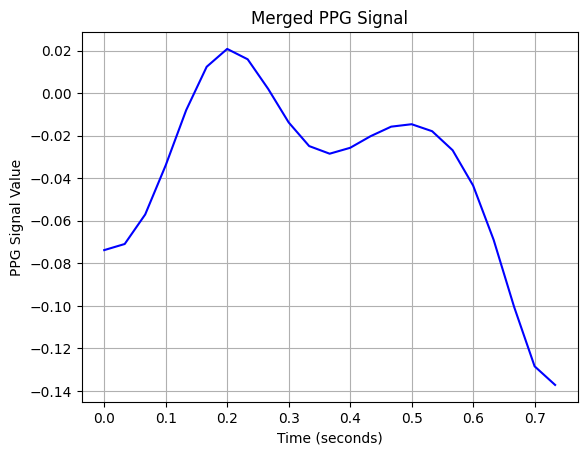

Detected PPG cycles for block 7, 0: [(49, 55, 58, 59, 69), (69, 75, 78, 82, 91), (162, 168, 171, 174, 185), (185, 191, 195, 197, 207)]
Sorted PPG cycles: [(185, 191, 195, 197, 207), (162, 168, 171, 174, 185), (69, 75, 78, 82, 91), (49, 55, 58, 59, 69)]
Selected PPG cycles 7, 0: [(185, 191, 195, 197, 207), (162, 168, 171, 174, 185), (69, 75, 78, 82, 91)]
Merged PPG signal: [-0.16533338 -0.14110409 -0.08661921 -0.01902271  0.04066176  0.07704248
  0.08637813  0.07644651  0.06098383  0.0519802   0.0538377   0.0622078
  0.06782786  0.06294683  0.04634185  0.02362012  0.00247781 -0.01378864
 -0.02952056 -0.05355785 -0.09118608 -0.13675811 -0.17294403 -0.09968447]


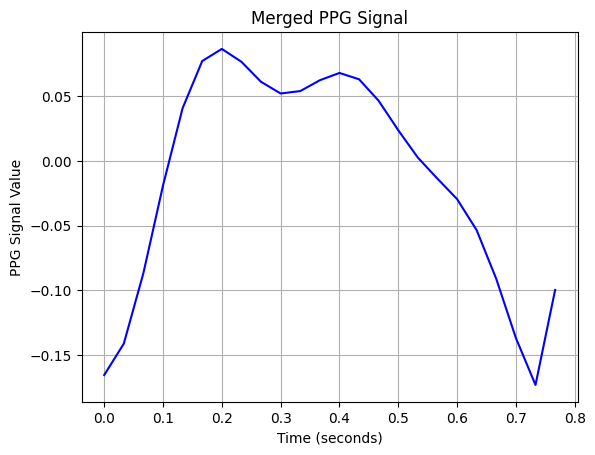

Detected PPG cycles for block 7, 1: [(69, 75, 79, 80, 91), (139, 145, 151, 155, 162), (162, 168, 172, 173, 185)]
Sorted PPG cycles: [(162, 168, 172, 173, 185), (139, 145, 151, 155, 162), (69, 75, 79, 80, 91)]
Selected PPG cycles 7, 1: [(162, 168, 172, 173, 185), (139, 145, 151, 155, 162), (69, 75, 79, 80, 91)]
Merged PPG signal: [-0.0838611  -0.07590086 -0.0473381  -0.00450358  0.03935299  0.07038514
  0.08123011  0.07435007  0.05945908  0.04686952  0.04136359  0.0406271
  0.03879163  0.03189033  0.02088312  0.01012622  0.00288749 -0.00221441
 -0.01082755 -0.02868261 -0.05666583 -0.08871941 -0.11407506 -0.10690039]


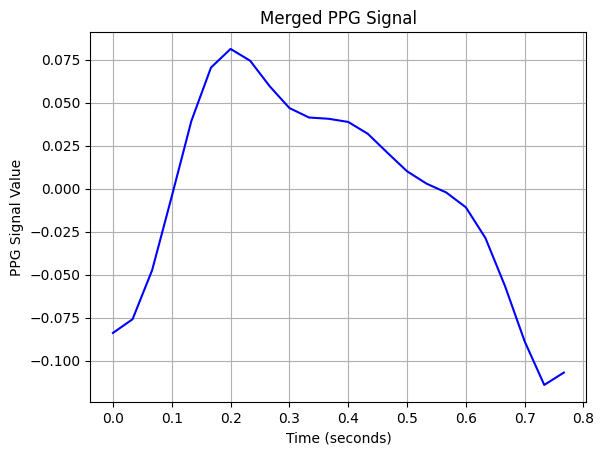

Detected PPG cycles for block 7, 2: [(88, 97, 102, 106, 115), (185, 190, 200, 201, 207)]
Sorted PPG cycles: [(185, 190, 200, 201, 207), (88, 97, 102, 106, 115)]
Selected PPG cycles 7, 2: [(185, 190, 200, 201, 207), (88, 97, 102, 106, 115), (185, 190, 200, 201, 207)]
Merged PPG signal: [-0.09179259 -0.07831107 -0.04977106 -0.01703014  0.0089208   0.02201453
  0.0228988   0.01691305  0.0099957   0.00525908  0.00218041 -0.00156532
 -0.00735459 -0.01411618 -0.01915517 -0.02054923 -0.01915227 -0.01853387
 -0.02275846 -0.03354547 -0.04877516 -0.06322119 -0.07074994 -0.0032629
 -0.00574485 -0.00825359 -0.00994687 -0.01023106]


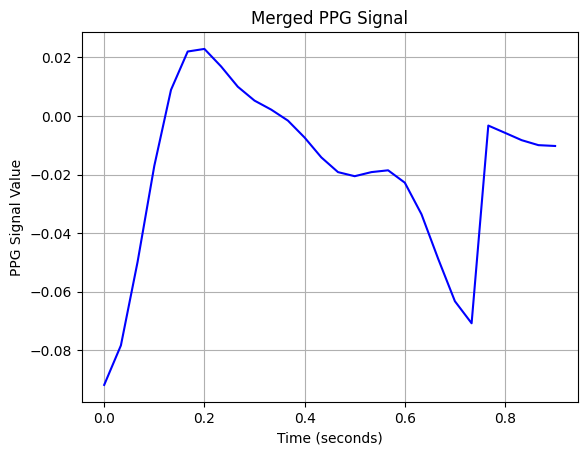

Detected PPG cycles for block 7, 3: [(91, 96, 99, 102, 118), (161, 168, 172, 173, 185)]
Sorted PPG cycles: [(161, 168, 172, 173, 185), (91, 96, 99, 102, 118)]
Selected PPG cycles 7, 3: [(161, 168, 172, 173, 185), (91, 96, 99, 102, 118), (161, 168, 172, 173, 185)]
Merged PPG signal: [-0.05651565 -0.0527895  -0.03546572 -0.00616364  0.02852991  0.0591983
  0.07773087  0.08131463  0.07374927  0.06295171  0.05599875  0.05489026
  0.05590159  0.0529405   0.04242781  0.02606675  0.00942334 -0.00258506
 -0.00978838 -0.01716525 -0.03098899 -0.05337336 -0.07919203 -0.09781113
 -0.09881012 -0.00875157 -0.0090938  -0.00918065]


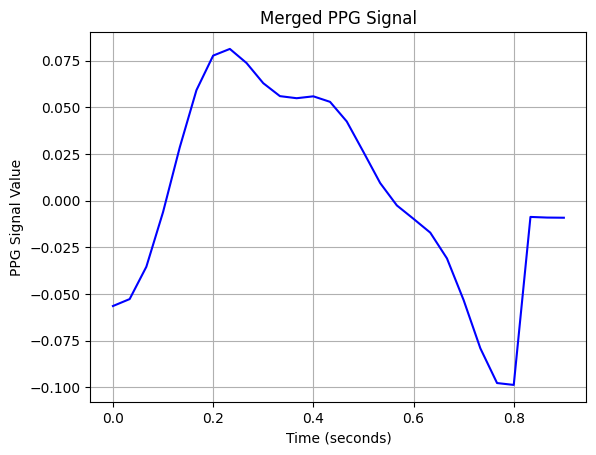

Detected PPG cycles for block 7, 4: [(69, 75, 80, 82, 91), (162, 168, 172, 174, 185)]
Sorted PPG cycles: [(162, 168, 172, 174, 185), (69, 75, 80, 82, 91)]
Selected PPG cycles 7, 4: [(162, 168, 172, 174, 185), (69, 75, 80, 82, 91), (162, 168, 172, 174, 185)]
Merged PPG signal: [-0.08574414 -0.07743015 -0.04605272  0.00480424  0.06255009  0.10975509
  0.1325592   0.12837399  0.10729687  0.08547483  0.07452331  0.07445468
  0.07533395  0.06632854  0.04495094  0.01895069 -0.00089077 -0.01128179
 -0.021296   -0.04662811 -0.09656239 -0.16319296 -0.2215928  -0.22858867]


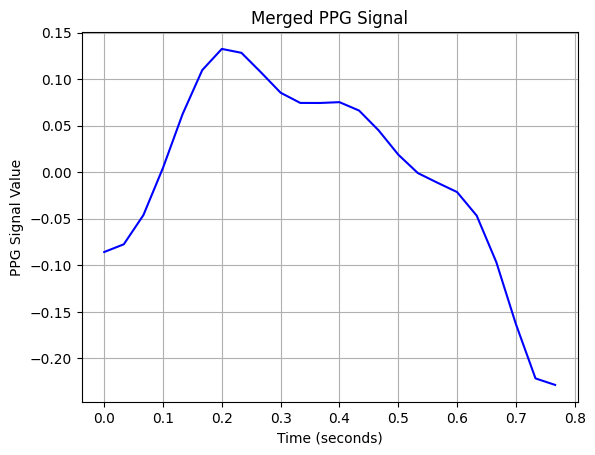

Detected PPG cycles for block 7, 5: []
Sorted PPG cycles: []
Selected PPG cycles 7, 5: []
Merged PPG signal: None
No merged signal to visualize.
Detected PPG cycles for block 7, 6: [(140, 146, 153, 156, 161)]
Sorted PPG cycles: [(140, 146, 153, 156, 161)]
Selected PPG cycles 7, 6: [(140, 146, 153, 156, 161), (140, 146, 153, 156, 161), (140, 146, 153, 156, 161)]
Merged PPG signal: [-0.07412767 -0.06614618 -0.04395514 -0.01173596  0.01980428  0.03925764
  0.04127004  0.02915271  0.01164485 -0.00325257 -0.01249029 -0.0175146
 -0.02059016 -0.02183876 -0.0197658  -0.01452041 -0.01045725 -0.01499859
 -0.03383832 -0.06560647 -0.09984624 -0.12017255]


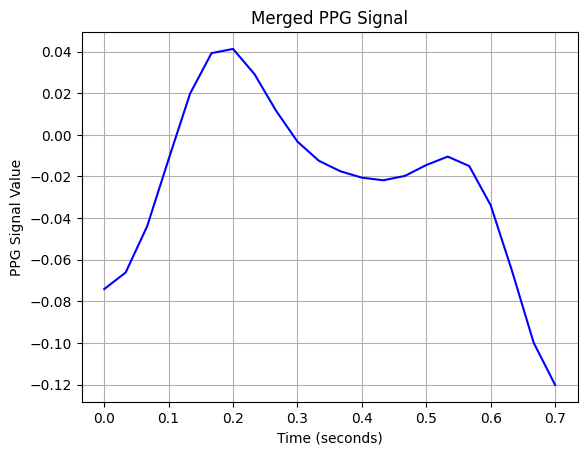

Detected PPG cycles for block 7, 7: [(2, 5, 9, 11, 22), (140, 146, 153, 155, 162)]
Sorted PPG cycles: [(140, 146, 153, 155, 162), (2, 5, 9, 11, 22)]
Selected PPG cycles 7, 7: [(140, 146, 153, 155, 162), (2, 5, 9, 11, 22), (140, 146, 153, 155, 162)]
Merged PPG signal: [-0.062203   -0.05623371 -0.04041471 -0.02144105 -0.00589456  0.00251773
  0.00375625  0.00017495 -0.00552167 -0.01159368 -0.01730791 -0.02228049
 -0.02603605 -0.02818603 -0.02894043 -0.02945567 -0.03178254 -0.03841666
 -0.05138687 -0.07075894 -0.09288887 -0.07899371 -0.08144059]


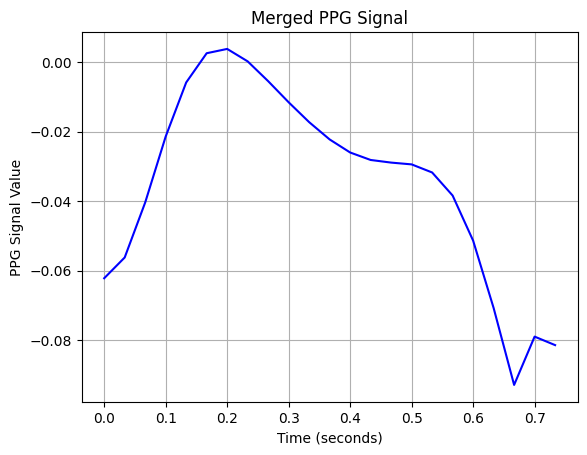

Detected PPG cycles for block 7, 8: [(141, 146, 151, 156, 162)]
Sorted PPG cycles: [(141, 146, 151, 156, 162)]
Selected PPG cycles 7, 8: [(141, 146, 151, 156, 162), (141, 146, 151, 156, 162), (141, 146, 151, 156, 162)]
Merged PPG signal: [-0.08393741 -0.07249531 -0.04625226 -0.01397232  0.01171903  0.02168678
  0.01515887 -0.00103993 -0.01759233 -0.02792269 -0.03014834 -0.02562769
 -0.01662771 -0.00551106  0.00441609  0.00822026  0.00052961 -0.02152616
 -0.05543558 -0.09243311 -0.11936968 -0.12272276]


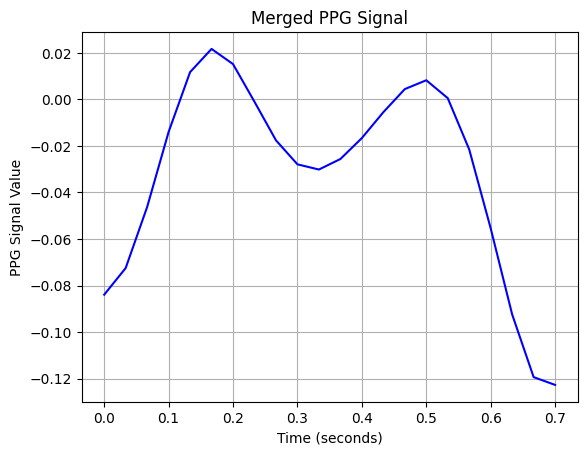

Detected PPG cycles for block 7, 9: []
Sorted PPG cycles: []
Selected PPG cycles 7, 9: []
Merged PPG signal: None
No merged signal to visualize.
Detected PPG cycles for block 8, 0: []
Sorted PPG cycles: []
Selected PPG cycles 8, 0: []
Merged PPG signal: None
No merged signal to visualize.
Detected PPG cycles for block 8, 1: [(162, 168, 172, 174, 185)]
Sorted PPG cycles: [(162, 168, 172, 174, 185)]
Selected PPG cycles 8, 1: [(162, 168, 172, 174, 185), (162, 168, 172, 174, 185), (162, 168, 172, 174, 185)]
Merged PPG signal: [-0.10833428 -0.09572746 -0.0531377   0.01727404  0.09964087  0.16903631
  0.2041181   0.19984191  0.1705714   0.14017382  0.1256315   0.1262429
  0.12658467  0.11068623  0.07587212  0.03493964  0.00482954 -0.00889088
 -0.01867514 -0.04651902 -0.10605165 -0.18855839 -0.26378554 -0.29581239]


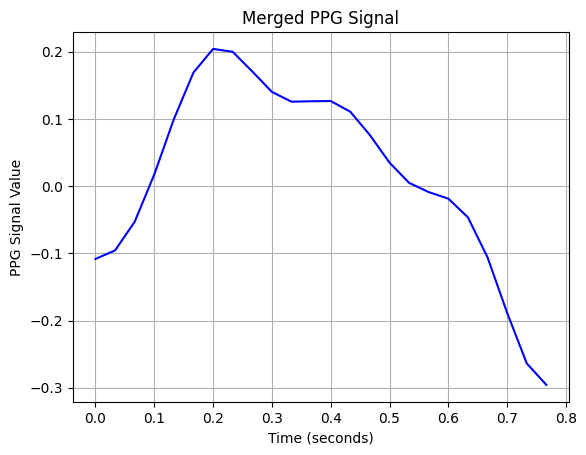

Detected PPG cycles for block 8, 2: [(47, 53, 63, 65, 69), (91, 96, 100, 103, 116)]
Sorted PPG cycles: [(91, 96, 100, 103, 116), (47, 53, 63, 65, 69)]
Selected PPG cycles 8, 2: [(91, 96, 100, 103, 116), (47, 53, 63, 65, 69), (91, 96, 100, 103, 116)]
Merged PPG signal: [-0.09094057 -0.07321691 -0.03835263  0.00354312  0.03942769  0.05974137
  0.06273695  0.0541329   0.04263205  0.03451328  0.03079852  0.02834934
  0.0234127   0.01473176  0.00417852 -0.00502351 -0.01079036 -0.01358601
 -0.01604801 -0.02132074 -0.0310998  -0.04428745 -0.05688985 -0.02883117
 -0.03526905 -0.03841678]


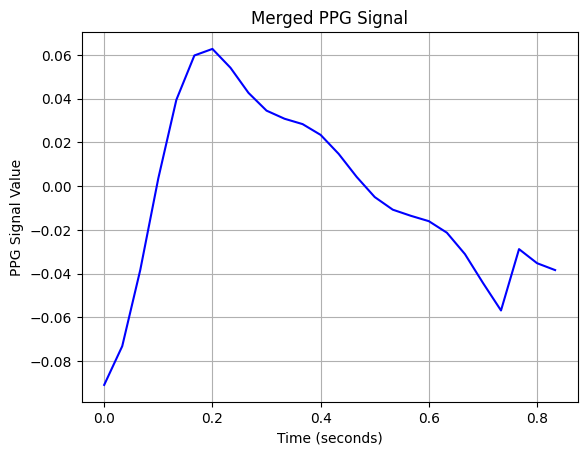

Detected PPG cycles for block 8, 3: [(120, 126, 130, 132, 140), (185, 191, 195, 197, 207)]
Sorted PPG cycles: [(185, 191, 195, 197, 207), (120, 126, 130, 132, 140)]
Selected PPG cycles 8, 3: [(185, 191, 195, 197, 207), (120, 126, 130, 132, 140), (185, 191, 195, 197, 207)]
Merged PPG signal: [-0.24194587 -0.22012197 -0.15087792 -0.05475963  0.03769578  0.09991141
  0.12047976  0.1062055   0.07608276  0.05002409  0.03867449  0.03969356
  0.04196521  0.03447397  0.01388989 -0.01398744 -0.03945912 -0.05668876
 -0.06808571 -0.08186935 -0.10436733 -0.12032261 -0.14207524]


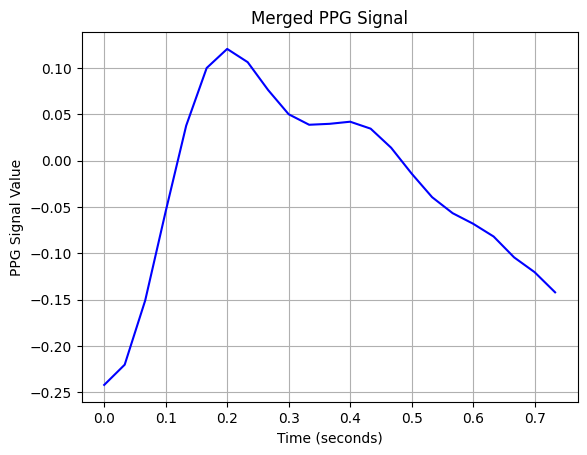

Detected PPG cycles for block 8, 4: [(139, 145, 151, 156, 162)]
Sorted PPG cycles: [(139, 145, 151, 156, 162)]
Selected PPG cycles 8, 4: [(139, 145, 151, 156, 162), (139, 145, 151, 156, 162), (139, 145, 151, 156, 162)]
Merged PPG signal: [-0.08878241 -0.08141226 -0.06291108 -0.03711929 -0.01023986  0.01077001
  0.02080924  0.01870005  0.00738563 -0.00776169 -0.02132013 -0.02952961
 -0.03081697 -0.02553754 -0.01556609 -0.00396395  0.0054548   0.00881283
  0.00302372 -0.01330669 -0.03885396 -0.06843953 -0.09249679 -0.09856206]


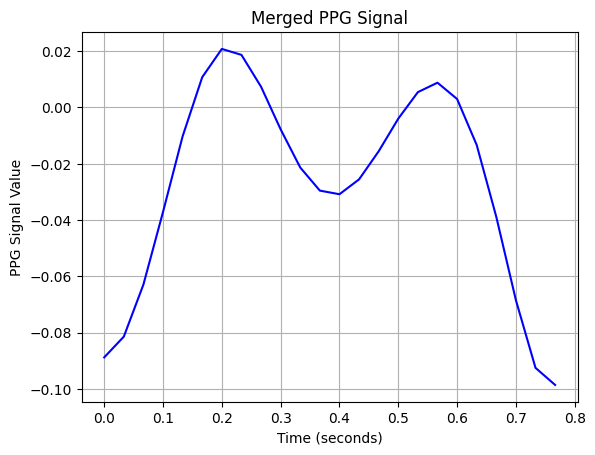

Detected PPG cycles for block 8, 5: [(91, 98, 100, 102, 117), (140, 146, 151, 156, 162)]
Sorted PPG cycles: [(140, 146, 151, 156, 162), (91, 98, 100, 102, 117)]
Selected PPG cycles 8, 5: [(140, 146, 151, 156, 162), (91, 98, 100, 102, 117), (140, 146, 151, 156, 162)]
Merged PPG signal: [-0.07316474 -0.06839673 -0.05083802 -0.02537642 -0.00022794  0.01682613
  0.02194965  0.01637935  0.00483746 -0.00727152 -0.0159627  -0.01924318
 -0.01673105 -0.00935384  0.0005094   0.00896991  0.01134305  0.0036907
 -0.01543029 -0.04372302 -0.07476528 -0.09867386 -0.10420846 -0.01985904
 -0.02368892 -0.02617873 -0.02720922]


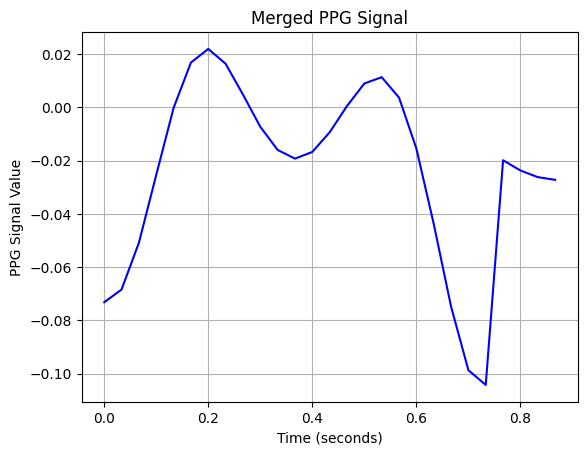

Detected PPG cycles for block 8, 6: [(141, 147, 152, 156, 162)]
Sorted PPG cycles: [(141, 147, 152, 156, 162)]
Selected PPG cycles 8, 6: [(141, 147, 152, 156, 162), (141, 147, 152, 156, 162), (141, 147, 152, 156, 162)]
Merged PPG signal: [-0.07641329 -0.07234488 -0.05422904 -0.02520014  0.00528357  0.02587381
  0.02905721  0.01472165 -0.01018398 -0.03520695 -0.05099206 -0.05279769
 -0.04179202 -0.02408347 -0.00818294 -0.00196484 -0.01019052 -0.03321705
 -0.06680775 -0.1025418  -0.12866765 -0.1320685 ]


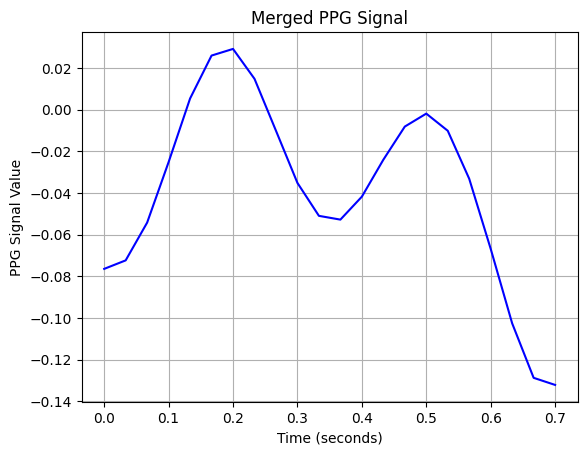

Detected PPG cycles for block 8, 7: [(91, 98, 100, 101, 117), (140, 146, 153, 155, 161)]
Sorted PPG cycles: [(140, 146, 153, 155, 161), (91, 98, 100, 101, 117)]
Selected PPG cycles 8, 7: [(140, 146, 153, 155, 161), (91, 98, 100, 101, 117), (140, 146, 153, 155, 161)]
Merged PPG signal: [-0.08810776 -0.08367722 -0.06318889 -0.03054227  0.00450003  0.03127158
  0.04373992  0.04282289  0.03425307  0.02411439  0.01555693  0.00866903
  0.00261705 -0.00251625 -0.00599608 -0.00834305 -0.01277028 -0.02433287
 -0.04679675 -0.07903284 -0.11325412 -0.13651702 -0.02107462 -0.02452782
 -0.02939003 -0.03494681 -0.03872431]


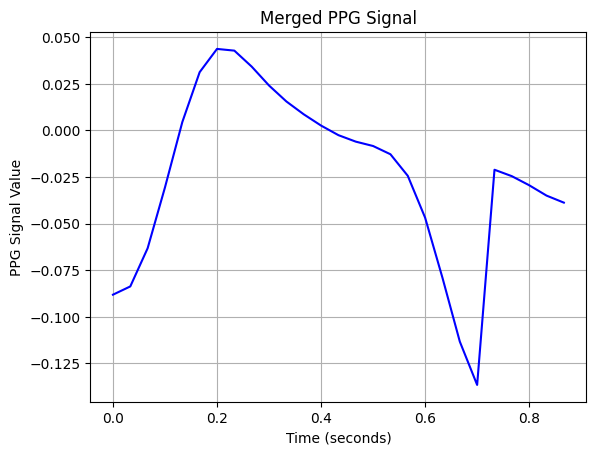

Detected PPG cycles for block 8, 8: [(92, 99, 103, 104, 116)]
Sorted PPG cycles: [(92, 99, 103, 104, 116)]
Selected PPG cycles 8, 8: [(92, 99, 103, 104, 116), (92, 99, 103, 104, 116), (92, 99, 103, 104, 116)]
Merged PPG signal: [-0.11290511 -0.09309995 -0.05544638 -0.00838059  0.03690611  0.07109929
  0.09007068  0.09541499  0.09244815  0.08714275  0.08360964  0.08297882
  0.08364619  0.08241017  0.07600525  0.06257383  0.04252652  0.01827487
 -0.00718232 -0.03200637 -0.05629289 -0.08105442 -0.10594197 -0.12744748
 -0.13929477]


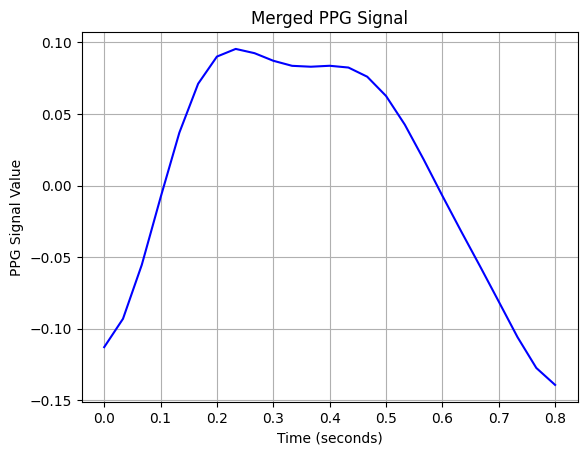

Detected PPG cycles for block 8, 9: [(140, 147, 152, 155, 162)]
Sorted PPG cycles: [(140, 147, 152, 155, 162)]
Selected PPG cycles 8, 9: [(140, 147, 152, 155, 162), (140, 147, 152, 155, 162), (140, 147, 152, 155, 162)]
Merged PPG signal: [-0.0856844  -0.08549435 -0.07234673 -0.0466302  -0.01411921  0.01618873
  0.03594247  0.04095199  0.03267743  0.01714429  0.00195652 -0.0070947
 -0.00820084 -0.00354504  0.00253519  0.00581091  0.00332305 -0.00693374
 -0.02659553 -0.05603064 -0.09156391 -0.12287025 -0.13391538]


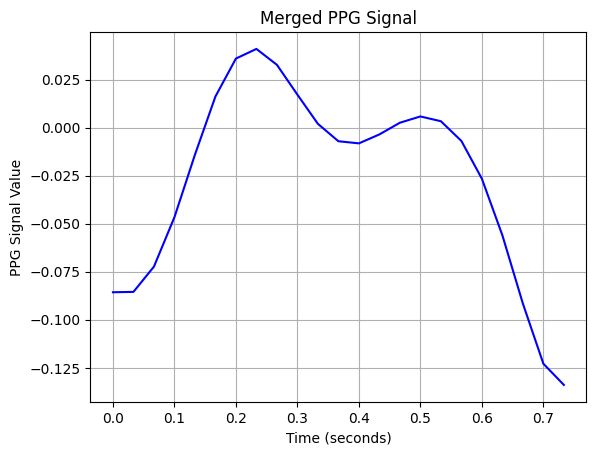

Detected PPG cycles for block 9, 0: [(162, 168, 172, 173, 185)]
Sorted PPG cycles: [(162, 168, 172, 173, 185)]
Selected PPG cycles 9, 0: [(162, 168, 172, 173, 185), (162, 168, 172, 173, 185), (162, 168, 172, 173, 185)]
Merged PPG signal: [-0.14229437 -0.1067705  -0.03479403  0.05791714  0.14498712  0.20131598
  0.21565143  0.19603854  0.16412421  0.14141877  0.13632895  0.1406469
  0.13774448  0.11633202  0.07949876  0.04218754  0.01894037  0.01125136
  0.00448274 -0.02254347 -0.08146976 -0.16300987 -0.2385232  -0.27427324]


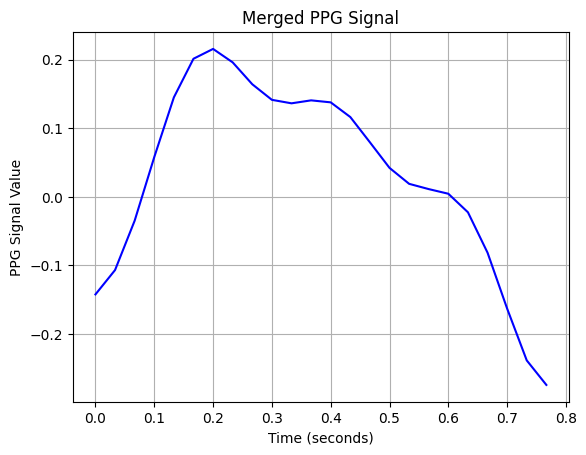

Detected PPG cycles for block 9, 1: [(120, 126, 131, 132, 139)]
Sorted PPG cycles: [(120, 126, 131, 132, 139)]
Selected PPG cycles 9, 1: [(120, 126, 131, 132, 139), (120, 126, 131, 132, 139), (120, 126, 131, 132, 139)]
Merged PPG signal: [-0.07567413 -0.06863946 -0.04373303 -0.00311689  0.04296567  0.08037444
  0.09829334  0.09496957  0.07811816  0.05968388  0.04851879  0.04582839
  0.04604318  0.04185279  0.02948466  0.0107308  -0.0089616  -0.02422139
 -0.03245794 -0.03415326]


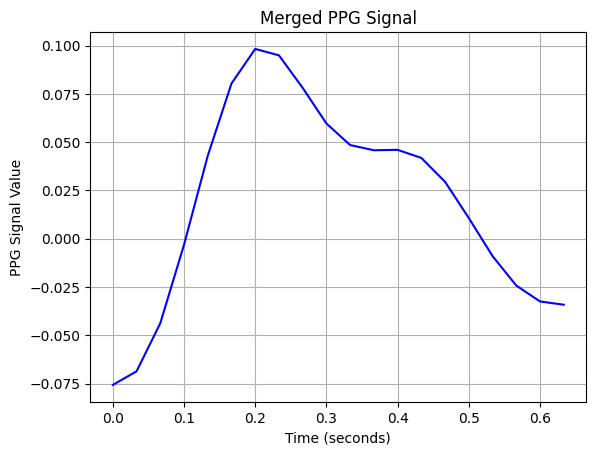

Detected PPG cycles for block 9, 2: [(140, 146, 152, 156, 161)]
Sorted PPG cycles: [(140, 146, 152, 156, 161)]
Selected PPG cycles 9, 2: [(140, 146, 152, 156, 161), (140, 146, 152, 156, 161), (140, 146, 152, 156, 161)]
Merged PPG signal: [-0.07065303 -0.06847602 -0.05644493 -0.03849526 -0.02125852 -0.01030319
 -0.00735279 -0.01037574 -0.01595084 -0.02163002 -0.0265133  -0.03019977
 -0.03173542 -0.02989375 -0.02460669 -0.01817751 -0.0150655  -0.02013912
 -0.03621244 -0.06181733 -0.08994474 -0.10853675]


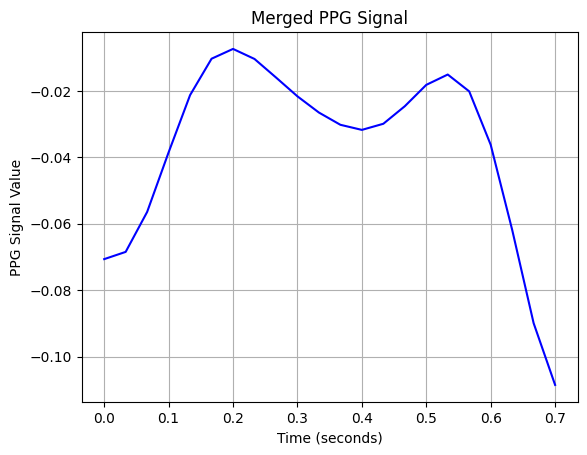

Detected PPG cycles for block 9, 3: [(47, 53, 56, 58, 69), (139, 146, 152, 156, 161)]
Sorted PPG cycles: [(139, 146, 152, 156, 161), (47, 53, 56, 58, 69)]
Selected PPG cycles 9, 3: [(139, 146, 152, 156, 161), (47, 53, 56, 58, 69), (139, 146, 152, 156, 161)]
Merged PPG signal: [-0.08519386 -0.08247471 -0.06566868 -0.03764978 -0.00563347  0.02100256
  0.03509499  0.03530591  0.02613789  0.01424624  0.00394929 -0.00457069
 -0.01329577 -0.0228573  -0.03098425 -0.03455765 -0.03356139 -0.0332918
 -0.04231425 -0.06687963 -0.10527114 -0.14585615 -0.17047884]


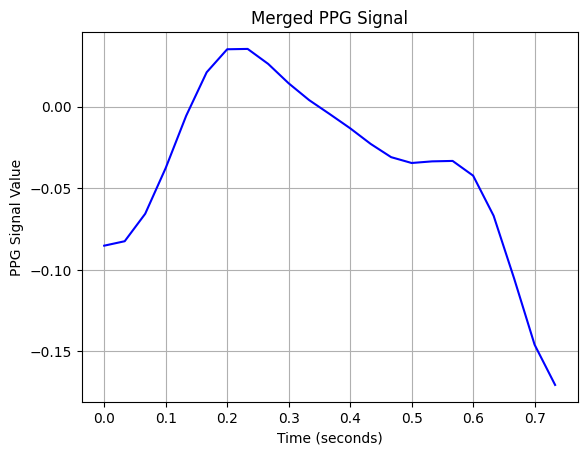

Detected PPG cycles for block 9, 4: [(139, 145, 151, 156, 161)]
Sorted PPG cycles: [(139, 145, 151, 156, 161)]
Selected PPG cycles 9, 4: [(139, 145, 151, 156, 161), (139, 145, 151, 156, 161), (139, 145, 151, 156, 161)]
Merged PPG signal: [-0.103798   -0.09975387 -0.07790014 -0.04324355 -0.00727854  0.01735622
  0.02362436  0.01330915 -0.00552278 -0.02437834 -0.03865609 -0.04750391
 -0.05065874 -0.04634464 -0.03279842 -0.01194842  0.00879094  0.01920715
  0.01200587 -0.01267483 -0.04710773 -0.07961658 -0.0987797 ]


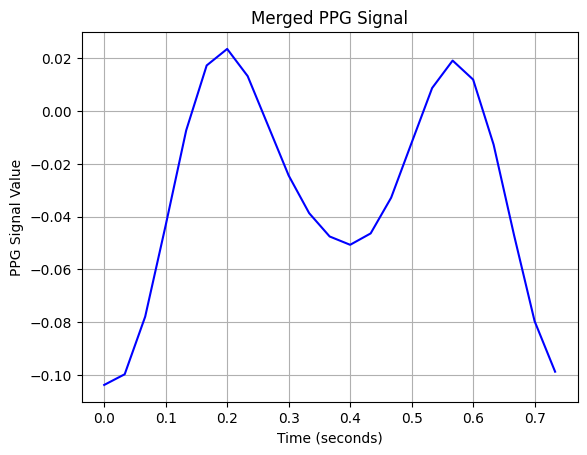

Detected PPG cycles for block 9, 5: [(140, 146, 154, 155, 161), (185, 191, 202, 203, 207)]
Sorted PPG cycles: [(185, 191, 202, 203, 207), (140, 146, 154, 155, 161)]
Selected PPG cycles 9, 5: [(185, 191, 202, 203, 207), (140, 146, 154, 155, 161), (185, 191, 202, 203, 207)]
Merged PPG signal: [-0.30974735 -0.28827011 -0.21009541 -0.09738234  0.01458785  0.09317048
  0.12223976  0.10724705  0.06937474  0.03257695  0.01103205  0.00399623
  0.00037313 -0.01084406 -0.03183937 -0.05515085 -0.07109348 -0.07740271
 -0.08296738 -0.10160931 -0.13947106 -0.185091   -0.15803293]


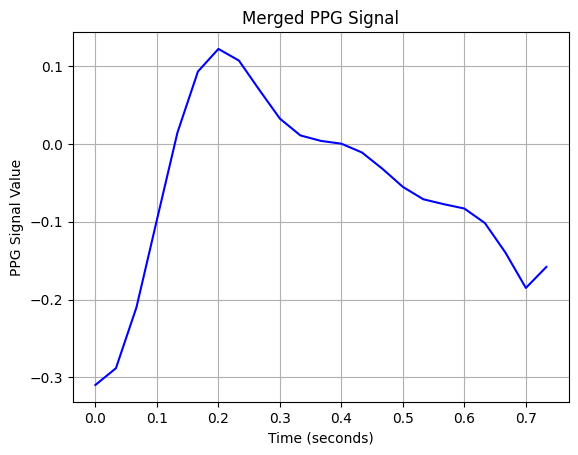

Detected PPG cycles for block 9, 6: [(91, 98, 102, 103, 116)]
Sorted PPG cycles: [(91, 98, 102, 103, 116)]
Selected PPG cycles 9, 6: [(91, 98, 102, 103, 116), (91, 98, 102, 103, 116), (91, 98, 102, 103, 116)]
Merged PPG signal: [-0.08820746 -0.08406463 -0.06566804 -0.03419524  0.00359049  0.03813026
  0.06159808  0.07141093  0.0706661   0.06551766  0.06139023  0.06036016
  0.06093952  0.05987286  0.05452764  0.04446052  0.03145615  0.0182055
  0.00645966 -0.00420388 -0.01609777 -0.03157641 -0.0507309  -0.07036671
 -0.08535272 -0.09166407]


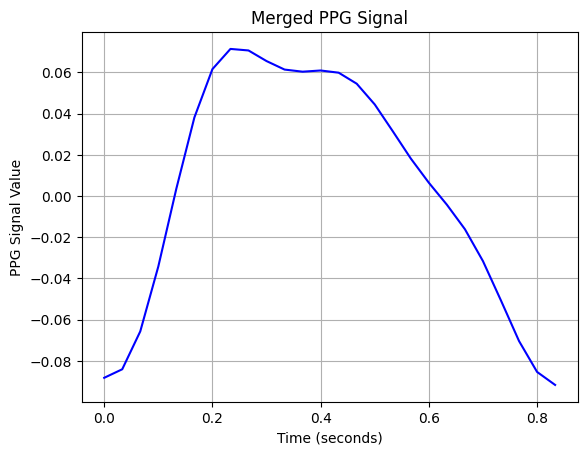

Detected PPG cycles for block 9, 7: []
Sorted PPG cycles: []
Selected PPG cycles 9, 7: []
Merged PPG signal: None
No merged signal to visualize.
Detected PPG cycles for block 9, 8: []
Sorted PPG cycles: []
Selected PPG cycles 9, 8: []
Merged PPG signal: None
No merged signal to visualize.
Detected PPG cycles for block 9, 9: []
Sorted PPG cycles: []
Selected PPG cycles 9, 9: []
Merged PPG signal: None
No merged signal to visualize.


In [20]:
all_ppg_cycles = []
all_selected_cycles = []
all_merged_signals = []

for i in range(10):
    for j in range(10):
        sppg_signal = SPPG[i, j, :]
        ppg_cycles = detect_ppg_cycles_for_one_signal(sppg_signal, sampling_rate)
        all_ppg_cycles.extend(ppg_cycles)
        print(f"Detected PPG cycles for block {i}, {j}:", ppg_cycles)

        selected_cycles = select_three_ppg_cycles(ppg_cycles)
        all_selected_cycles.extend(selected_cycles)
        print(f"Selected PPG cycles {i}, {j}:", selected_cycles)

        merged_signal = merge_ppg_cycles(sppg_signal, selected_cycles)
        print("Merged PPG signal:", merged_signal)
        visualize_merged_signal(merged_signal, sampling_rate)
        all_merged_signals.append(merged_signal)

In [21]:
all_merged_signals

[None,
 array([-0.00802637, -0.00782768, -0.00741058, -0.00679002, -0.00594928,
        -0.00492676, -0.00388719, -0.00303363, -0.0024054 , -0.00177464,
        -0.00079126,  0.00073025,  0.0026682 ,  0.00476189,  0.00692266,
         0.00931351,  0.01200762,  0.01449135,  0.01556427,  0.01395906,
         0.00937407,  0.0031215 , -0.00226395, -0.00436811, -0.00233925,
         0.00256414,  0.00768995,  0.01045505,  0.00958751,  0.00547788,
        -0.00032121, -0.00590584, -0.00964708, -0.01052897]),
 array([-0.0391804 , -0.03593546, -0.02844471, -0.01904697, -0.01011712,
        -0.0027854 ,  0.00350396,  0.0101545 ,  0.01791106,  0.02597969,
         0.03262542,  0.03677753,  0.03913242,  0.04153721,  0.04495787,
         0.04778282,  0.04620813,  0.03682047,  0.01954709, -0.00141868,
        -0.01968495, -0.03038098, -0.03288177, -0.030657  , -0.02854999,
        -0.02960727, -0.0336339 , -0.03808607, -0.04015581, -0.01277925,
        -0.01318785]),
 array([-0.03887659, -0.03831515

In [22]:
type(all_merged_signals)

list

In [23]:
# Remove None values
filtered_array = [cycle for cycle in all_merged_signals if cycle is not None]


In [24]:
# Convert the filtered list to a NumPy array
all_merged_signals = filtered_array

In [25]:
# for merged in filtered_array:
#     print(merged.shape)

In [26]:
######## Feature Extraction###########

In [27]:
# def extract_features(merged_signal, sampling_rate):
#     if merged_signal is None:
#         return []  # Return an empty list when merged_signal is None
    
#     all_features = []

    # # Smooth the merged signal using Savitzky-Golay filtering
    # smoothed_signal = savgol_filter(merged_signal, window_length=15, polyorder=3)

    # # Compute the 1st and 2nd derivatives of the smoothed signal
    # first_derivative = np.gradient(smoothed_signal)
    # second_derivative = np.gradient(first_derivative)

    # # Find peaks and valleys in the smoothed signal
    # peaks, _ = find_peaks(smoothed_signal, distance=int(sampling_rate * 0.5))
    # valleys, _ = find_peaks(-smoothed_signal, distance=int(sampling_rate * 0.5))

    # print("Peaks:", peaks)
    # print("Valleys:", valleys)


    # # Systolic peak height
    # systolic_peak_height = np.max(smoothed_signal)
    # all_features.append(systolic_peak_height)

    # # Diatolic peak height
    # diastolic_peak_height = np.min(smoothed_signal[valleys])
    # all_features.append(diastolic_peak_height)

    # print(smoothed_signal[peaks], smoothed_signal[valleys])

    # # Dicrotic notch height
    # dicrotic_notch_height = smoothed_signal[peaks][1] - smoothed_signal[valleys][1]
    # all_features.append(dicrotic_notch_height)

    # # Pulse interval
    # pulse_interval = (peaks[1] - peaks[0]) / sampling_rate
    # all_features.append(pulse_interval)

    # # Augmentation index
    # augmentation_index = (systolic_peak_height - diastolic_peak_height) / diastolic_peak_height * 100
    # all_features.append(augmentation_index)

    # # Relative augmentation index
    # relative_augmentation_index = (systolic_peak_height - diastolic_peak_height) / systolic_peak_height * 100
    # all_features.append(relative_augmentation_index)

    # # Ratio of z and x
    # z_x_ratio = dicrotic_notch_height / systolic_peak_height
    # all_features.append(z_x_ratio)

    # # Negative relative augmentation index
    # negative_relative_augmentation_index = (diastolic_peak_height - systolic_peak_height) / diastolic_peak_height * 100
    # all_features.append(negative_relative_augmentation_index)

    # # Systolic peak time
    # systolic_peak_time = peaks[0] / sampling_rate
    # all_features.append(systolic_peak_time)

    # # Dicrotic notch time
    # dicrotic_notch_time = peaks[1] / sampling_rate
    # all_features.append(dicrotic_notch_time)

    # # Diastolic peak time
    # diastolic_peak_time = valleys[0] / sampling_rate
    # all_features.append(diastolic_peak_time)









    # # Time between systolic and diastolic peaks
    # time_between_peaks = (peaks[0] - valleys[0]) / sampling_rate
    # features.append(time_between_peaks)

    # # Time between half systolic peak points
    # half_systolic_peak_time = (peaks[0] - valleys[1]) / sampling_rate
    # # features.append(half_systolic_peak_time)

    # # Inflection point area ratio
    # inflection_point_area_ratio = np.trapz(smoothed_signal[valleys[0]:peaks[1]]) / np.trapz(smoothed_signal[peaks[0]:valleys[0]])
    # features.append(inflection_point_area_ratio)
    
    # # Systolic peak rising slope
    # systolic_peak_rising_slope = (smoothed_signal[peaks[0]] - smoothed_signal[valleys[0]]) / time_between_peaks
    # features.append(systolic_peak_rising_slope)
    
    # # Diatolic peak falling slope
    # diatolic_peak_falling_slope = (smoothed_signal[valleys[0]] - smoothed_signal[peaks[1]]) / time_between_peaks
    # features.append(diatolic_peak_falling_slope)
    
    # # Ratio of t1 and pulse interval time (tpi)
    # t1_tpi_ratio = time_between_peaks / pulse_interval
    # features.append(t1_tpi_ratio)

    # # Ratio of t2 and pulse interval time (tpi)
    # t2_tpi_ratio = half_systolic_peak_time / pulse_interval
    # features.append(t2_tpi_ratio)

    # # Ratio of t3 and pulse interval time (tpi)
    # t3_tpi_ratio = (peaks[1] - valleys[1]) / sampling_rate / pulse_interval
    # features.append(t3_tpi_ratio)

    # # Ratio of deltaT and pulse interval time (tpi)
    # deltaT_tpi_ratio = (valleys[1] - peaks[0]) / sampling_rate / pulse_interval
    # features.append(deltaT_tpi_ratio)
    
    # # Interval time from first PPG cycle start point (l1) in first derivative of PPF (Sf) to first maxima (a1) of Sf
    # ta1 = peaks[0] - valleys[0]
    # features.append(ta1)

    # # Interval time from point l1 to first minima of first PPG cycle (b1) in the Sf
    # tb1 = valleys[0] - peaks[0]
    # features.append(tb1)
    
    # # Interval time from point l1 to second minima of the first PPG cycle (f1) in the Sf
    # tf1 = valleys[1] - peaks[0]
    # features.append(tf1)
    
    # # Ratio of first minima (b2) and first maxima (a2) in the second derivative of PPG signal (Sf2)
    # b2_a2_ratio = second_derivative[valleys[0]] / second_derivative[peaks[0]]
    # features.append(b2_a2_ratio)
    
    # # Ratio od second maxima (e2) in Sf2 and a2
    # e2_a2_ratio = second_derivative[peaks[1]] / second_derivative[peaks[0]]
    # features.append(e2_a2_ratio)
    
    # # Ratio of (b2+e2) and a2 [40]
    # b2_e2_a2_ratio = (second_derivative[valleys[0]] + second_derivative[peaks[1]]) / second_derivative[peaks[0]]
    # features.append(b2_e2_a2_ratio)
    
    # # Interval time from the second PPG cycle start point (l2) in second derivative of PPG to a2
    # ta2 = peaks[0] - valleys[0]
    # features.append(ta2)
    
    # # Interval time from point l2 ti b2
    # tb2 = valleys[0] - peaks[0]
    # features.append(tb2)
    
    # # Ratio of ta1 and tpi
    # ta1_tpi_ratio = ta1 / pulse_interval
    # features.append(ta1_tpi_ratio)
    
    # # Ratio of tb1 and tpi
    # tb1_tpi_ratio = tb1 / pulse_interval
    # features.append(tb1_tpi_ratio)
    
    # # Ratio of te1 and tpi
    # te1_tpi_ratio = (valleys[1] - peaks[0]) / sampling_rate / pulse_interval
    # features.append(te1_tpi_ratio)
    
    # # Ratio of time interval of l1 (tl1) and tpi
    # tl1_tpi_ratio = valleys[0] / sampling_rate / pulse_interval
    # features.append(tl1_tpi_ratio)
    
    # # Ratio of ta2 and tpi
    # ta2_tpi_ratio = ta2 / pulse_interval
    # features.append(ta2_tpi_ratio)
    
    # # Ratio of tb2 and tpi
    # tb2_tpi_ratio = tb2 / pulse_interval
    # features.append(tb2_tpi_ratio)
    
    # # Ratio of ta1+ta2 and pulse interval (tpi)
    # ta1_ta2_tpi_ratio = (ta1 + ta2) / pulse_interval
    # features.append(ta1_ta2_tpi_ratio)
    
    # # Ratio of (tb1+tb2) and pulse interval (tpi)
    # tb1_tb2_tpi_ratio = (tb1 + tb2) / pulse_interval 
    # features.append(tb1_tb2_tpi_ratio)
       
    # # Ratio of (te1+t2) and pulse interval (tpi)
    # te1_te2_tpi_ratio = (te1_tpi_ratio + tb2_tpi_ratio)
    # features.append(te1_te2_tpi_ratio)
    
    # # Ratio of tl1+t3 and pulse interval (tpi)
    # tl1_t3_tpi_ratio = (tl1_tpi_ratio + t3_tpi_ratio)
    # features.append(tl1_t3_tpi_ratio)
    
    # # Fundamental component frequency obtained from Fast Fourier Transformation (FFT)
    # fbase = np.argmax(fft(smoothed_signal))
    # features.append(fbase)
    
    # # Fundamental component magnitude from FFT
    # fbase_magnitude = np.max(fft(smoothed_signal))
    # features.append(fbase_magnitude)
    
    # # Second component frequency obtained from FFT. Such that, fbase<f2nd
    # f2nd = np.argmax(fft(smoothed_signal[fbase:]))
    # features.append(f2nd)
    
    # # Second component magnitude from FFT
    # f2nd_magnitude = np.max(fft(smoothed_signal[fbase:]))
    # features.append(f2nd_magnitude)
    
    # # Third component frequency obtained from FFT. Such that, fbase<f2nd<f3rd
    # f3rd = np.argmax(fft(smoothed_signal[f2nd:]))
    # features.append(f3rd)
    
    # # Third component magnitude acquired from FFT
    # f3rd_magnitude = np.max(fft(smoothed_signal[f2nd:]))
    # features.append(f3rd_magnitude)

    # print("Smoothed Signal:", smoothed_signal)
    # print("First Derivative:", first_derivative)
    # print("Second Derivative:", second_derivative)

    # # Append features to the list
    # all_features.append(features)

    # return all_features


In [33]:
def extract_features(merged_signal, sampling_rate):
    features = {}
    
    peaks = argrelmax(np.array(merged_signal))[0]
    valleys = argrelmin(np.array(merged_signal))[0]

    
    # Ensure peaks and valleys are not empty
    if len(peaks) <=1 or len(valleys) == 0:
        return features
    
   
    systolic_peak_height = merged_signal[peaks[0]]
    features['systolic_peak_height'] = systolic_peak_height

    diastolic_peak_height = merged_signal[peaks[1]]
    features['diastolic_peak_height'] = diastolic_peak_height
    
    dicrotic_notch_height =  merged_signal[valleys[0]]
    features['dicrotic_notch_height'] = dicrotic_notch_height

    # Calculate pulse interval
    pulse_interval = len(merged_signal) / sampling_rate
    features['pulse_interval'] = pulse_interval

    # Calculate augmentation index
    augmentation_index = diastolic_peak_height / systolic_peak_height
    features['augmentation_index'] = augmentation_index
    
    # Calculate relative augmentation index
    relative_augmentation_index = (systolic_peak_height - diastolic_peak_height) / systolic_peak_height
    features['relative_augmentation_index'] = relative_augmentation_index
    
    # Calculate ratio of z and x
    ratio_z_x = dicrotic_notch_height / systolic_peak_height
    features['ratio_z_x'] = ratio_z_x

    # Calculate negative relative augmentation index
    negative_relative_augmentation_index = (diastolic_peak_height - dicrotic_notch_height) / systolic_peak_height
    features['negative_relative_augmentation_index'] = negative_relative_augmentation_index

    # Calculate systolic peak time
    systolic_peak_time = (peaks[0]+1) / sampling_rate
    features['systolic_peak_time'] = systolic_peak_time
    
    # Calculate dicrotic notch time
    dicrotic_notch_time = (valleys[0]+1) / sampling_rate
    features['dicrotic_notch_time'] = dicrotic_notch_time
    
    # Calculate diastolic peak time
    diastolic_peak_time = (peaks[1]+1) / sampling_rate
    features['diastolic_peak_time'] = diastolic_peak_time
    
    # Calculate time between systolic and diastolic peaks
    time_between_peaks = diastolic_peak_time - systolic_peak_time
    features['time_between_peaks'] = time_between_peaks
    

    try: 
        # Calculate time between half systolic peak points
        half_systolic_peak = systolic_peak_height / 2
        half_systolic_peak_points = np.where(merged_signal >= half_systolic_peak)[0]
        time_between_half_systolic_peak_points = (half_systolic_peak_points[-1] - half_systolic_peak_points[0]) / sampling_rate
        features['time_between_half_systolic_peak_points'] = time_between_half_systolic_peak_points
    except:
        features['time_between_half_systolic_peak_points'] = None
  
  
    # Inflection point area ratio
    inflection_point_area_ratio=sum(merged_signal[:peaks[0]]) / sum(merged_signal[peaks[0]:])
    features['inflection_point_area_ratio'] = inflection_point_area_ratio
    
    # Systolic peak rising slope
    systolic_peak_rising_slope=(systolic_peak_time / systolic_peak_height)
    features['systolic_peak_rising_slope']=systolic_peak_rising_slope
    
    # Diastolic peak falling slope
    diastolic_peak_falling_slope=(diastolic_peak_height / pulse_interval-diastolic_peak_time)
    features['diastolic_peak_falling_slope']=diastolic_peak_falling_slope
    
    # Ratio of t1 and pulse interval time (tpi)
    t1_tpi_ratio = systolic_peak_time / pulse_interval
    features['t1_tpi_ratio'] = t1_tpi_ratio
    
    # Ratio of t2 and pulse interval time (tpi)
    t2_tpi_ratio = dicrotic_notch_time/ pulse_interval
    features['t2_tpi_ratio'] = t2_tpi_ratio
    
    # Ratio of t3 and pulse interval time (tpi)
    t3_tpi_ratio = diastolic_peak_time / pulse_interval
    features['t3_tpi_ratio'] = t3_tpi_ratio
    
    # Ratio of deltaT and pulse interval time (tpi)
    deltaT_tpi_ratio = time_between_peaks / pulse_interval
    features['deltaT_tpi_ratio'] = deltaT_tpi_ratio
    
    return features

# Example usage
# sampling_rate = fps
# extracted_features = extract_features(all_merged_signals[79], sampling_rate)
# print("Extracted features:", extracted_features)


all_extracted_features = []
count=0
for merged_signal in all_merged_signals:
    count+=1
    print(count)
    extracted_features = extract_features(merged_signal, sampling_rate)
    print("Extracted features:", extracted_features)
    all_extracted_features.extend(extracted_features)

1
Extracted features: {'systolic_peak_height': 0.015564272290874086, 'diastolic_peak_height': 0.010455051809855233, 'dicrotic_notch_height': -0.004368105336682223, 'pulse_interval': 1.1333333333333333, 'augmentation_index': 0.6717340595477388, 'relative_augmentation_index': 0.32826594045226126, 'ratio_z_x': -0.28064950644967873, 'negative_relative_augmentation_index': 0.9523835659974175, 'systolic_peak_time': 0.6333333333333333, 'dicrotic_notch_time': 0.8, 'diastolic_peak_time': 0.9333333333333333, 'time_between_peaks': 0.30000000000000004, 'time_between_half_systolic_peak_points': 0.43333333333333335, 'inflection_point_area_ratio': -0.04543541610865904, 'systolic_peak_rising_slope': 40.691483771116, 'diastolic_peak_falling_slope': -0.9241082876187552, 't1_tpi_ratio': 0.5588235294117647, 't2_tpi_ratio': 0.7058823529411765, 't3_tpi_ratio': 0.823529411764706, 'deltaT_tpi_ratio': 0.26470588235294124}
2
Extracted features: {'systolic_peak_height': 0.04778282266182434, 'diastolic_peak_heigh